# **üè† Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä Baseline code**
> Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞Ä ÏòàÏ∏° ÎåÄÌöåÏóê Ïò§Ïã† Ïó¨Îü¨Î∂Ñ ÌôòÏòÅÌï©ÎãàÎã§! üéâ     
> ÏïÑÎûò baselineÏóêÏÑúÎäî RandomForestÎ•º ÌôúÏö©Ìï¥ ML Î∞©Î≤ïÎ°†Îì§ÏùÑ Ïã§Ï†ú ÎåÄÌöåÏóê Ï†ÅÏö©Ìï¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
> Í∞ïÏùòÎäî google colabÏúºÎ°ú Ïã§ÌñâÌïòÏòÄÍ∏∞Ïóê ÏïÑÎûòÏùò Î≤†Ïù¥Ïä§ÎùºÏù∏ ÏΩîÎìúÏôÄÎäî ÏùºÎ∂Ä Ï∞®Ïù¥Í∞Ä ÏûàÏùÑ Ïàò ÏûàÏäµÎãàÎã§. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º Î∂àÎü¨ÏòµÎãàÎã§.

In [807]:
!pip install eli5==0.13.0

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÇ¨Ïö©ÏùÑ ÏúÑÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ÏûÖÎãàÎã§.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [808]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf ÌååÏùºÏù¥ Ï†ÄÏû•ÎêòÏñ¥ ÏûàÎäî Í≤ΩÎ°ú
    name='NanumBarunGothic')                        # Ïù¥ Ìè∞Ìä∏Ïùò ÏõêÌïòÎäî Ïù¥Î¶Ñ ÏÑ§Ï†ï
fm.fontManager.ttflist.insert(0, fe)              # MatplotlibÏóê Ìè∞Ìä∏ Ï∂îÍ∞Ä
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import re
import math
from geopy.geocoders import Nominatim
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from functools import partial
import eli5
from eli5.sklearn import PermutationImportance
import optuna

#### Util Functions

In [809]:
geo_local = Nominatim(user_agent='South Korea')

# Ï£ºÏÜå -> Í≤ΩÎèÑ, ÏúÑÎèÑ Î∞òÌôòÌïòÎäî Ìï®Ïàò
def get_coordinates(addr):
    try:
        geo = geo_local.geocode(addr)
        x, y = geo.longitude, geo.latitude
        return x, y
    except:
        return np.nan, np.nan

# Ï£ºÏñ¥ÏßÑ ÌñâÍ≥º ÏúÑÏπò Îç∞Ïù¥ÌÑ∞Ïùò Î™®Îì† ÏßÄÏ†ê Í∞ÑÏùò Í±∞Î¶¨ Í≥ÑÏÇ∞ Î∞è Ï°∞Í±¥ÏùÑ ÎßåÏ°±ÌïòÎäî ÏßÄÏ†êÏùò Í∞úÏàò Î∞òÌôò
def calculate_distances_vectorized(row, df_loc, distance, alpha=0):
    row_coords = np.radians(np.array([row[0], row[1]]))
    df_coords = np.radians(df_loc[['Ï¢åÌëúY', 'Ï¢åÌëúX']].values.T)
    distances = np.linalg.norm(row_coords[:, np.newaxis] - df_coords, axis=0) * 6371000  # row_coords Î∏åÎ°úÎìúÏ∫êÏä§ÌåÖ
    return np.sum((distances + alpha <= distance).astype(int))

# Î≥ëÎ†¨ Ï≤òÎ¶¨
def get_number_of_object(df_main, df_object, distances, alpha=0):
    df_main_loc = df_main[['Ï¢åÌëúY', 'Ï¢åÌëúX']]
    df_object_loc = df_object[['Ï¢åÌëúY', 'Ï¢åÌëúX']]

    with ThreadPoolExecutor() as executor:
        result = list(executor.map(lambda row_train: calculate_distances_vectorized(row_train, df_object_loc, distances),
                                    tqdm(df_main_loc.itertuples(index=False),
                                        total=len(df_main_loc), desc='Building Iteration', position=1)))

    df = pd.DataFrame(result)
    return df

# ÏúÑÎèÑ, Í≤ΩÎèÑÎ°ú Îëê ÏßÄÏ†êÍ∞ÑÏùò Í±∞Î¶¨ Í≥ÑÏÇ∞
def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371.0

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = radius * c
    return distance

## 2. Data Load

#### 2.1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú

In [810]:
# ÌïÑÏöîÌïú Îç∞Ïù¥ÌÑ∞Î•º load ÌïòÍ≤†ÏäµÎãàÎã§. Í≤ΩÎ°úÎäî ÌôòÍ≤ΩÏóê ÎßûÍ≤å ÏßÄÏ†ïÌï¥Ï£ºÎ©¥ Îê©ÎãàÎã§.
train_path = '../train.csv'
test_path  = '../test.csv'
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Train dataÏôÄ Test data shapeÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§.
print('Train data shape : ', df_train.shape, 'Test data shape : ', df_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [811]:
df_train.head(3)

ÏãúÍµ∞Íµ¨     Î≤àÏßÄ     Î≥∏Î≤à   Î∂ÄÎ≤à    ÏïÑÌååÌä∏Î™Ö  Ï†ÑÏö©Î©¥Ï†Å(„é°)    Í≥ÑÏïΩÎÖÑÏõî  Í≥ÑÏïΩÏùº  Ï∏µ  Í±¥Ï∂ïÎÖÑÎèÑ  \
0  ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎÇ®Íµ¨ Í∞úÌè¨Îèô  658-1  658.0  1.0  Í∞úÌè¨6Ï∞®Ïö∞ÏÑ±    79.97  201712    8  3  1987   
1  ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎÇ®Íµ¨ Í∞úÌè¨Îèô  658-1  658.0  1.0  Í∞úÌè¨6Ï∞®Ïö∞ÏÑ±    79.97  201712   22  4  1987   
2  ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎÇ®Íµ¨ Í∞úÌè¨Îèô  658-1  658.0  1.0  Í∞úÌè¨6Ï∞®Ïö∞ÏÑ±    54.98  201712   28  5  1987   

   ...    Í±¥Ï∂ïÎ©¥Ï†Å   Ï£ºÏ∞®ÎåÄÏàò Í∏∞ÌÉÄ/ÏùòÎ¨¥/ÏûÑÎåÄ/ÏûÑÏùò=1/2/3/4                  Îã®ÏßÄÏäπÏù∏Ïùº ÏÇ¨Ïö©ÌóàÍ∞ÄÏó¨Î∂Ä  \
0  ...  4858.0  262.0                  ÏûÑÏùò  2022-11-17 13:00:29.0      Y   
1  ...  4858.0  262.0                  ÏûÑÏùò  2022-11-17 13:00:29.0      Y   
2  ...  4858.0  262.0                  ÏûÑÏùò  2022-11-17 13:00:29.0      Y   

  Í¥ÄÎ¶¨ÎπÑ ÏóÖÎ°úÎìú        Ï¢åÌëúX        Ï¢åÌëúY                  Îã®ÏßÄÏã†Ï≤≠Ïùº  target  
0       N  127.05721  37.476763  2022-11-17 10:19:06.0  124000  
1       N  127.05721  37.476763  2022-11-17 10:19:06.0  123500  
2       N  127.05721  37.476763  2022-11-17 10:19:06.0   91500  

[3 rows x 52 columns]

In [812]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   ÏãúÍµ∞Íµ¨                     1118822 non-null  object 
 1   Î≤àÏßÄ                      1118597 non-null  object 
 2   Î≥∏Î≤à                      1118747 non-null  float64
 3   Î∂ÄÎ≤à                      1118747 non-null  float64
 4   ÏïÑÌååÌä∏Î™Ö                    1116696 non-null  object 
 5   Ï†ÑÏö©Î©¥Ï†Å(„é°)                 1118822 non-null  float64
 6   Í≥ÑÏïΩÎÖÑÏõî                    1118822 non-null  int64  
 7   Í≥ÑÏïΩÏùº                     1118822 non-null  int64  
 8   Ï∏µ                       1118822 non-null  int64  
 9   Í±¥Ï∂ïÎÖÑÎèÑ                    1118822 non-null  int64  
 10  ÎèÑÎ°úÎ™Ö                     1118822 non-null  object 
 11  Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº                 5983 non-null     float64
 12  Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê              

## 3. Data Preprocessing

- Î™®Îç∏ÎßÅ Ï†ÑÏóê Îç∞Ïù¥ÌÑ∞ ÎÇ¥ Í≤∞Ï∏°Ïπò, Ïù¥ÏÉÅÏπò Îì±ÏùÑ Ï†úÍ±∞ÌïòÍ≥† Î≤îÏ£ºÌòïÍ≥º Ïó∞ÏÜçÌòï Î≥ÄÏàòÎ•º ÏÇ¥Ìé¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§!
- Î®ºÏ†Ä, Ïö©Ïù¥Ìïú Ï†ÑÏ≤òÎ¶¨Î•º ÏúÑÌï¥ trainÍ≥º test dataÎ•º Ìï©Ïπú ÌïòÎÇòÏùò Îç∞Ïù¥ÌÑ∞Î°ú ÏßÑÌñâÌïòÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

In [813]:
# train/test Íµ¨Î∂ÑÏùÑ ÏúÑÌïú ÏπºÎüºÏùÑ ÌïòÎÇò ÎßåÎì§Ïñ¥ Ï§çÎãàÎã§.
df_train['is_test'] = 0
df_test['is_test'] = 1

# trainÍ≥º test data ÌïòÎÇòÎ°ú Ìï©ÏπòÍ∏∞
concat = pd.concat([df_train, df_test]) 
concat = concat.reset_index()

concat['is_test'].value_counts()   

0    1118822
1       9272
Name: is_test, dtype: int64

In [814]:
# ÏπºÎüº Ïù¥Î¶ÑÏùÑ ÏâΩÍ≤å Î∞îÍøîÏ£ºÍ≤†ÏäµÎãàÎã§. Îã§Î•∏ ÏπºÎüºÎèÑ ÏÇ¨Ïö©Ïóê Îî∞Îùº Î∞îÍøîÏ£ºÏÖîÎèÑ Îê©ÎãàÎã§!
concat = concat.rename(columns={'Ï†ÑÏö©Î©¥Ï†Å(„é°)':'Ï†ÑÏö©Î©¥Ï†Å'})
concat = concat.rename(columns={'k-Îã®ÏßÄÎ∂ÑÎ•ò(ÏïÑÌååÌä∏,Ï£ºÏÉÅÎ≥µÌï©Îì±Îì±)':'k-Îã®ÏßÄÎ∂ÑÎ•ò'})
concat = concat.rename(columns={'Í∏∞ÌÉÄ/ÏùòÎ¨¥/ÏûÑÎåÄ/ÏûÑÏùò=1/2/3/4':'Í∏∞ÌÉÄ/ÏùòÎ¨¥/ÏûÑÎåÄ/ÏûÑÏùò'})
concat = concat.rename(columns={'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°Ïù¥Ìïò)':'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄ_60'})
concat = concat.rename(columns={'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄÌòÑÌô©(60„é°~85„é°Ïù¥Ìïò)':'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄ_60_85'})
concat = concat.rename(columns={'k-85„é°~135„é°Ïù¥Ìïò':'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄ_85_135'})
concat = concat.rename(columns={'k-135„é°Ï¥àÍ≥º':'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄ_135'})
concat = concat.rename(columns={'Í¥ÄÎ¶¨ÎπÑ ÏóÖÎ°úÎìú':'Í¥ÄÎ¶¨ÎπÑÏóÖÎ°úÎìú'})

# ÌïÑÏöî ÏóÜÎäî Ïª¨Îüº Ï†úÍ±∞
concat = concat.drop(['k-Ï†ÑÌôîÎ≤àÌò∏', 'k-Ìå©Ïä§Î≤àÌò∏', 'Îã®ÏßÄÏÜåÍ∞úÍ∏∞Ï°¥clob', 'k-ÌôàÌéòÏù¥ÏßÄ',
                            'Í≥†Ïö©Î≥¥ÌóòÍ¥ÄÎ¶¨Î≤àÌò∏', 'Ï§ëÍ∞úÏÇ¨ÏÜåÏû¨ÏßÄ', 'k-ÏàòÏ†ïÏùºÏûê', 'k-Îì±Î°ùÏùºÏûê',
                            'Ìï¥Ï†úÏÇ¨Ïú†Î∞úÏÉùÏùº', 'Îì±Í∏∞Ïã†Ï≤≠ÏùºÏûê', 'k-ÏÇ¨Ïö©Í≤ÄÏÇ¨Ïùº-ÏÇ¨Ïö©ÏäπÏù∏Ïùº', 'Îã®ÏßÄÏã†Ï≤≠Ïùº', 'Îã®ÏßÄÏäπÏù∏Ïùº',
                            ], axis=1)

# ÏßÄÎ≤àÏ£ºÏÜå Ïª¨Îüº Ï∂îÍ∞Ä
concat['ÏßÄÎ≤àÏ£ºÏÜå'] = concat['ÏãúÍµ∞Íµ¨'] + ' ' + concat['Î≥∏Î≤à'].astype('str').str.replace(r'\.0', '')
concat['ÏßÄÎ≤àÏ£ºÏÜå'] += np.where(concat['Î∂ÄÎ≤à'].astype('str').str.replace(r'\.0', '') != '0', '-' + concat['Î∂ÄÎ≤à'].astype('str').str.replace(r'\.0', ''), '')

# ÎèÑÎ°úÎ™Ö ' 'Ïù∏ Í≤ΩÏö∞ ÏïÑÌååÌä∏Î™ÖÏúºÎ°ú ÎåÄÏ≤¥
concat.loc[concat['ÎèÑÎ°úÎ™Ö'] == ' ', 'ÎèÑÎ°úÎ™Ö'] = concat.loc[concat['ÎèÑÎ°úÎ™Ö'] == ' ', 'ÏïÑÌååÌä∏Î™Ö']

### 3.1. Í≤∞Ï∏°Ïπò ÌÉêÏÉâ Î∞è Î≥¥Í∞Ñ
- Í≤∞Ï∏°ÏπòÎ•º Ï≤òÎ¶¨Ìï† Îïå ÎßéÏù¥ Ïì∞Îäî Î∞©Î≤ïÏùÄ ÏÇ≠Ï†ú(Deletion)Í≥º ÎåÄÏ≤¥(Imputation) ÏûÖÎãàÎã§.
- Î≥∏ ÏΩîÎìúÏóêÏÑúÎäî Í≤∞Ï∏°ÏπòÍ∞Ä 80ÎßåÍ∞ú Ïù¥ÏÉÅÏù∏ ÏùºÎ∂Ä Î≥ÄÏàòÎäî Ï†úÍ±∞ÌïòÍ≥†, ÎÇòÎ®∏ÏßÄ Î≥ÄÏàòÏùò Í≤∞Ï∏°ÏπòÎäî ÎåÄÏ≤¥ÌïòÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
  - ÏàòÏπòÌòï Î≥ÄÏàòÏùò Í≤ΩÏö∞ÏóêÎäî ÌöåÍ∑Ä Î™®Îç∏Ïóê Í∏∞Î∞òÌïòÏó¨ ÎåÄÏ≤¥ÌïòÍ≤†ÏäµÎãàÎã§.
  - Î≤îÏ£ºÌòï Î≥ÄÏàòÏùò Í≤ΩÏö∞ÏóêÎäî 'NULL' Ïù¥ÎùºÎäî ÏûÑÏùòÏùò Î≤îÏ£ºÎ°ú ÎåÄÏ≤¥Ìï¥Ï£ºÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

In [815]:
# Ïã§Ï†úÎ°ú Í≤∞Ï∏°ÏπòÎùºÍ≥† ÌëúÏãúÎäî ÏïàÎêòÏñ¥ÏûàÏßÄÎßå ÏïÑÎ¨¥ ÏùòÎØ∏ÎèÑ Í∞ñÏßÄ ÏïäÎäî elementÎì§Ïù¥ ÏïÑÎûòÏôÄ Í∞ôÏù¥ Ï°¥Ïû¨Ìï©ÎãàÎã§.
display(concat['Í±∞ÎûòÏú†Ìòï'].value_counts())

-       1086451
Ï§ëÍ∞úÍ±∞Îûò      38123
ÏßÅÍ±∞Îûò        3520
Name: Í±∞ÎûòÏú†Ìòï, dtype: int64

In [816]:
# ÏúÑ Ï≤òÎüº ÏïÑÎ¨¥ ÏùòÎØ∏ÎèÑ Í∞ñÏßÄ ÏïäÎäî ÏπºÎüºÏùÄ Í≤∞Ï∏°ÏπòÏôÄ Í∞ôÏùÄ Ïó≠Ìï†ÏùÑ ÌïòÎØÄÎ°ú, np.nanÏúºÎ°ú Ï±ÑÏõå Í≤∞Ï∏°ÏπòÎ°ú Ïù∏ÏãùÎêòÎèÑÎ°ù Ìï©ÎãàÎã§.
concat['Í±∞ÎûòÏú†Ìòï'] = concat['Í±∞ÎûòÏú†Ìòï'].replace('-', np.nan)

# EDAÏóê ÏïûÏÑú Í≤∞Ï∏°ÏπòÎ•º ÌôïÏù∏Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.
concat.isnull().sum()

index                     0
ÏãúÍµ∞Íµ¨                       0
Î≤àÏßÄ                      227
Î≥∏Î≤à                       75
Î∂ÄÎ≤à                       75
ÏïÑÌååÌä∏Î™Ö                   2136
Ï†ÑÏö©Î©¥Ï†Å                      0
Í≥ÑÏïΩÎÖÑÏõî                      0
Í≥ÑÏïΩÏùº                       0
Ï∏µ                         0
Í±¥Ï∂ïÎÖÑÎèÑ                      0
ÎèÑÎ°úÎ™Ö                       0
Í±∞ÎûòÏú†Ìòï                1086451
k-Îã®ÏßÄÎ∂ÑÎ•ò               877273
k-ÏÑ∏ÎåÄÌÉÄÏûÖ(Î∂ÑÏñëÌòïÌÉú)         876125
k-Í¥ÄÎ¶¨Î∞©Ïãù               876125
k-Î≥µÎèÑÏú†Ìòï               876454
k-ÎÇúÎ∞©Î∞©Ïãù               876125
k-Ï†ÑÏ≤¥ÎèôÏàò               877207
k-Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò              876125
k-Í±¥ÏÑ§ÏÇ¨(ÏãúÍ≥µÏÇ¨)           877637
k-ÏãúÌñâÏÇ¨                877834
k-Ïó∞Î©¥Ï†Å                876125
k-Ï£ºÍ±∞Ï†ÑÏö©Î©¥Ï†Å             876170
k-Í¥ÄÎ¶¨ÎπÑÎ∂ÄÍ≥ºÎ©¥Ï†Å            876125
k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄ_60         876170
k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄ_60_85      876170
k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄ_85_1

- ÏúÑ Í∑∏ÎûòÌîÑÏóêÏÑú Î≥º Ïàò ÏûàÎã§ÏãúÌîº Í≤∞Ï∏°ÏπòÍ∞Ä 100ÎßåÍ∞ú Ïù¥ÏÉÅÏù∏ ÏπºÎüºÎì§ÏùÄ Í≤∞Ï∏°ÏπòÍ∞Ä Ìï¥Îãπ ÏπºÎüºÏùò element Ï§ë 90% Ïù¥ÏÉÅÏùÑ Ï∞®ÏßÄÌïòÎäî ÏÉÅÌô©Ïù¥ Îê©ÎãàÎã§.
- Îî∞ÎùºÏÑú Î≥∏ Baseline ÏóêÏÑúÎäî Ïù¥ ÏπºÎüºÏùÄ ÏòàÏ∏°Ïóê ÎèÑÏõÄÏù¥ ÎêòÏßÄ ÏïäÎäîÎã§Í≥† ÌåêÎã®Ìï¥ ÏÇ≠Ï†úÌï¥Ï£ºÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

#### NaNÍ∞íÏù¥ 80ÎßåÍ∞ú Ïù¥ÏÉÅÏù∏ ÏπºÎüº ÏÇ≠Ï†ú

In [817]:
# NaNÍ∞íÏù¥ 80ÎßåÍ∞ú Ïù¥ÏÉÅÏù∏ ÏπºÎüºÏùÄ ÏÇ≠Ï†úÌï¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
print('* Í≤∞Ï∏°ÏπòÍ∞Ä 80ÎßåÍ∞ú Ïù¥ÌïòÏù∏ Î≥ÄÏàòÎì§ :', list(concat.columns[concat.isnull().sum() <= 800000]))     # ÎÇ®Í≤®Ïßà Î≥ÄÏàòÎì§ÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§.
print('* Í≤∞Ï∏°ÏπòÍ∞Ä 80ÎßåÍ∞ú Ïù¥ÏÉÅÏù∏ Î≥ÄÏàòÎì§ :', list(concat.columns[concat.isnull().sum() >= 800000]))

* Í≤∞Ï∏°ÏπòÍ∞Ä 80ÎßåÍ∞ú Ïù¥ÌïòÏù∏ Î≥ÄÏàòÎì§ : ['index', 'ÏãúÍµ∞Íµ¨', 'Î≤àÏßÄ', 'Î≥∏Î≤à', 'Î∂ÄÎ≤à', 'ÏïÑÌååÌä∏Î™Ö', 'Ï†ÑÏö©Î©¥Ï†Å', 'Í≥ÑÏïΩÎÖÑÏõî', 'Í≥ÑÏïΩÏùº', 'Ï∏µ', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'ÎèÑÎ°úÎ™Ö', 'target', 'is_test', 'ÏßÄÎ≤àÏ£ºÏÜå']
* Í≤∞Ï∏°ÏπòÍ∞Ä 80ÎßåÍ∞ú Ïù¥ÏÉÅÏù∏ Î≥ÄÏàòÎì§ : ['Í±∞ÎûòÏú†Ìòï', 'k-Îã®ÏßÄÎ∂ÑÎ•ò', 'k-ÏÑ∏ÎåÄÌÉÄÏûÖ(Î∂ÑÏñëÌòïÌÉú)', 'k-Í¥ÄÎ¶¨Î∞©Ïãù', 'k-Î≥µÎèÑÏú†Ìòï', 'k-ÎÇúÎ∞©Î∞©Ïãù', 'k-Ï†ÑÏ≤¥ÎèôÏàò', 'k-Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò', 'k-Í±¥ÏÑ§ÏÇ¨(ÏãúÍ≥µÏÇ¨)', 'k-ÏãúÌñâÏÇ¨', 'k-Ïó∞Î©¥Ï†Å', 'k-Ï£ºÍ±∞Ï†ÑÏö©Î©¥Ï†Å', 'k-Í¥ÄÎ¶¨ÎπÑÎ∂ÄÍ≥ºÎ©¥Ï†Å', 'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄ_60', 'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄ_60_85', 'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄ_85_135', 'k-Ï†ÑÏö©Î©¥Ï†ÅÎ≥ÑÏÑ∏ÎåÄ_135', 'Í≤ΩÎπÑÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú', 'ÏÑ∏ÎåÄÏ†ÑÍ∏∞Í≥ÑÏïΩÎ∞©Î≤ï', 'Ï≤≠ÏÜåÎπÑÍ¥ÄÎ¶¨ÌòïÌÉú', 'Í±¥Ï∂ïÎ©¥Ï†Å', 'Ï£ºÏ∞®ÎåÄÏàò', 'Í∏∞ÌÉÄ/ÏùòÎ¨¥/ÏûÑÎåÄ/ÏûÑÏùò', 'ÏÇ¨Ïö©ÌóàÍ∞ÄÏó¨Î∂Ä', 'Í¥ÄÎ¶¨ÎπÑÏóÖÎ°úÎìú', 'Ï¢åÌëúX', 'Ï¢åÌëúY']


In [818]:
# Í≤∞Ï∏°ÏπòÍ∞Ä 80ÎßåÍ∞ú Ïù¥ÌïòÏù∏ Î≥ÄÏàò + ÏùºÎ∂Ä Ïª¨ÎüºÎì§Îßå Í≥®Îùº ÏÉàÎ°úÏö¥ concat_select Í∞ùÏ≤¥Î°ú Ï†ÄÏû•Ìï¥Ï§çÎãàÎã§.
selected = list(concat.columns[concat.isnull().sum() <= 800000])
selected += ['Ï¢åÌëúX', 'Ï¢åÌëúY', 'k-Î≥µÎèÑÏú†Ìòï', 'k-Îã®ÏßÄÎ∂ÑÎ•ò', 'Ï£ºÏ∞®ÎåÄÏàò']
concat_select = concat[selected]

In [819]:
concat_select.isnull().sum() # targetÎ≥ÄÏàòÎäî test dataset Í∞úÏàòÎßåÌÅº(9272) Í≤∞Ï∏°ÏπòÍ∞Ä Ï°¥Ïû¨Ìï®ÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

index           0
ÏãúÍµ∞Íµ¨             0
Î≤àÏßÄ            227
Î≥∏Î≤à             75
Î∂ÄÎ≤à             75
ÏïÑÌååÌä∏Î™Ö         2136
Ï†ÑÏö©Î©¥Ï†Å            0
Í≥ÑÏïΩÎÖÑÏõî            0
Í≥ÑÏïΩÏùº             0
Ï∏µ               0
Í±¥Ï∂ïÎÖÑÎèÑ            0
ÎèÑÎ°úÎ™Ö             0
target       9272
is_test         0
ÏßÄÎ≤àÏ£ºÏÜå            0
Ï¢åÌëúX        876232
Ï¢åÌëúY        876232
k-Î≥µÎèÑÏú†Ìòï     876454
k-Îã®ÏßÄÎ∂ÑÎ•ò     877273
Ï£ºÏ∞®ÎåÄÏàò       876277
dtype: int64

#### ÏÑúÏö∏Ïãú Í≥µÎèôÏ£ºÌÉù ÏïÑÌååÌä∏ Ï†ïÎ≥¥Î°ú ÏùºÎ∂Ä Í≤∞Ï∏°Ïπò ÎåÄÏ≤¥

In [820]:
# Í≤∞Ï∏°Ïπò ÎåÄÏ≤¥Î•º ÏúÑÌï¥ ÏÑúÏö∏Ïãú Í≥µÎèôÏ£ºÌÉù ÏïÑÌååÌä∏ Ï†ïÎ≥¥ load (https://data.seoul.go.kr/dataList/OA-15818/A/1/datasetView.do )
apt_path = '../apartments.csv'
df_apt = pd.read_csv(apt_path, encoding='cp949')

# 'ÎèÑÎ°úÎ™ÖÏ£ºÏÜå'Î•º Í∏∞Ï§ÄÏúºÎ°ú df_trainÏùò Í≤∞Ï∏°Ïπò ÎåÄÏ≤¥ ('ÏïÑÌååÌä∏Î™Ö'ÏùÄ Í∞ôÏùÄ ÏïÑÌååÌä∏ÏûÑÏóêÎèÑ ÏÑúÎ°ú ÏùºÏπòÌïòÏßÄ ÏïäÎäî Ìï≠Î™©Ïù¥ ÎßéÏïÑÏÑú)
df_apt['ÎèÑÎ°úÎ™ÖÏ£ºÏÜå'] = df_apt['Ï£ºÏÜå(ÎèÑÎ°úÎ™Ö)'] + ' ' + df_apt['Ï£ºÏÜå(ÎèÑÎ°úÏÉÅÏÑ∏Ï£ºÏÜå)']
df_apt_unique = df_apt.drop_duplicates(subset='ÎèÑÎ°úÎ™ÖÏ£ºÏÜå')

concat_select['Ï¢åÌëúX'] = concat_select['Ï¢åÌëúX'].fillna(concat_select['ÎèÑÎ°úÎ™Ö'].map(df_apt_unique.set_index('ÎèÑÎ°úÎ™ÖÏ£ºÏÜå')['Ï¢åÌëúX'])).astype('float')
concat_select['Ï¢åÌëúY'] = concat_select['Ï¢åÌëúY'].fillna(concat_select['ÎèÑÎ°úÎ™Ö'].map(df_apt_unique.set_index('ÎèÑÎ°úÎ™ÖÏ£ºÏÜå')['Ï¢åÌëúY']))

concat_select['k-Îã®ÏßÄÎ∂ÑÎ•ò'] = concat_select['k-Îã®ÏßÄÎ∂ÑÎ•ò'].fillna(concat_select['ÎèÑÎ°úÎ™Ö'].map(df_apt_unique.set_index('ÎèÑÎ°úÎ™ÖÏ£ºÏÜå')['k-Îã®ÏßÄÎ∂ÑÎ•ò(ÏïÑÌååÌä∏,Ï£ºÏÉÅÎ≥µÌï©Îì±Îì±)']))
concat_select['k-Î≥µÎèÑÏú†Ìòï'] = concat_select['k-Î≥µÎèÑÏú†Ìòï'].fillna(concat_select['ÎèÑÎ°úÎ™Ö'].map(df_apt_unique.set_index('ÎèÑÎ°úÎ™ÖÏ£ºÏÜå')['k-Î≥µÎèÑÏú†Ìòï']))
concat_select['Ï£ºÏ∞®ÎåÄÏàò'] = concat_select['Ï£ºÏ∞®ÎåÄÏàò'].fillna(concat_select['ÎèÑÎ°úÎ™Ö'].map(df_apt_unique.set_index('ÎèÑÎ°úÎ™ÖÏ£ºÏÜå')['Ï£ºÏ∞®ÎåÄÏàò']))

concat_select.isnull().sum()

index           0
ÏãúÍµ∞Íµ¨             0
Î≤àÏßÄ            227
Î≥∏Î≤à             75
Î∂ÄÎ≤à             75
ÏïÑÌååÌä∏Î™Ö         2136
Ï†ÑÏö©Î©¥Ï†Å            0
Í≥ÑÏïΩÎÖÑÏõî            0
Í≥ÑÏïΩÏùº             0
Ï∏µ               0
Í±¥Ï∂ïÎÖÑÎèÑ            0
ÎèÑÎ°úÎ™Ö             0
target       9272
is_test         0
ÏßÄÎ≤àÏ£ºÏÜå            0
Ï¢åÌëúX        257152
Ï¢åÌëúY        257152
k-Î≥µÎèÑÏú†Ìòï     257608
k-Îã®ÏßÄÎ∂ÑÎ•ò     259137
Ï£ºÏ∞®ÎåÄÏàò       259357
dtype: int64

#### geopy ÎùºÏù¥Î∏åÎü¨Î¶¨Î°ú ÎÇòÎ®∏ÏßÄ Ï¢åÌëú Í≤∞Ï∏°Ïπò ÎåÄÏ≤¥

In [821]:
# 'ÎèÑÎ°úÎ™Ö'Ïù¥ Í∞ôÏùÄ Í¥ÄÏ∏°ÏπòÎÅºÎ¶¨ Ìïú Î≤àÎßå Ï¢åÌëúÍ∞íÏùÑ Í∞ÄÏ†∏Ïò§ÎèÑÎ°ù Ï≤òÎ¶¨
# unique_roads = df_concat_select[df_concat_select['Ï¢åÌëúX'].isnull()]['ÎèÑÎ°úÎ™Ö'].unique()

# for road in tqdm(unique_roads):
#     mask = (df_concat_select['ÎèÑÎ°úÎ™Ö'] == road) & (df_concat_select['Ï¢åÌëúX'].isnull())

#     if mask.any():
#         coordinates = get_coordinates(road)

#         # Í∞ÄÏ†∏Ïò® Ï¢åÌëúÍ∞íÏùÑ Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî Í¥ÄÏ∏°ÏπòÏóê Ï±ÑÏö∞Í∏∞
#         df_concat_select.loc[mask, ['Ï¢åÌëúX', 'Ï¢åÌëúY']] = coordinates

# # Ï¢åÌëúX, Ï¢åÌëúY Í≤∞Ï∏°Ïπò ÎåÄÏ≤¥ ÌõÑ ÎÇ®ÏùÄ Í≤∞Ï∏°Ïπò ÌôïÏù∏
# df_concat_select[['Ï¢åÌëúX', 'Ï¢åÌëúY']].isnull().sum()

In [822]:
# # ÎÇ®ÏùÄ Ï¢åÌëúX, Ï¢åÌëúY Í≤∞Ï∏°ÏπòÎäî ÏßÄÎ≤àÏ£ºÏÜåÎ•º ÏÇ¨Ïö©Ìï¥ Í∞ÄÏ†∏Ïò§Í∏∞
# unique_roads = df_concat_select[df_concat_select['Ï¢åÌëúX'].isnull()]['ÏßÄÎ≤àÏ£ºÏÜå'].unique()

# for road in tqdm(unique_roads):
#     mask = (df_concat_select['ÏßÄÎ≤àÏ£ºÏÜå'] == road) & (df_concat_select['Ï¢åÌëúX'].isnull())

#     if mask.any():
#         coordinates = get_coordinates(road)
#         df_concat_select.loc[mask, ['Ï¢åÌëúX', 'Ï¢åÌëúY']] = coordinates

# # Ï¢åÌëúX, Ï¢åÌëúY Í≤∞Ï∏°Ïπò ÎåÄÏ≤¥ ÌõÑ ÎÇ®ÏùÄ Í≤∞Ï∏°Ïπò ÌôïÏù∏
# df_concat_select[['Ï¢åÌëúX', 'Ï¢åÌëúY']].isnull().sum()

In [823]:
# df_concat_select[df_concat_select['Ï¢åÌëúX'].isnull()]['ÏßÄÎ≤àÏ£ºÏÜå'].unique()

# df_concat_select.loc[df_concat_select['ÏßÄÎ≤àÏ£ºÏÜå'] == 'ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÎÖ∏ÏõêÍµ¨ ÏÉÅÍ≥ÑÎèô 95-274', ['Ï¢åÌëúX', 'Ï¢åÌëúY']] = 127.077516, 37.664439
# df_concat_select.loc[df_concat_select['ÏßÄÎ≤àÏ£ºÏÜå'] == 'ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÎèôÎåÄÎ¨∏Íµ¨ Ïù¥Î¨∏Îèô 257-516', ['Ï¢åÌëúX', 'Ï¢åÌëúY']] = 127.059407, 37.600432

# df_concat_select[['Ï¢åÌëúX', 'Ï¢åÌëúY']].to_csv(base_path + 'coordinates.csv', index=False)

# # Ï¢åÌëúX, Ï¢åÌëúY Í≤∞Ï∏°Ïπò ÎåÄÏ≤¥ ÌõÑ ÎÇ®ÏùÄ Í≤∞Ï∏°Ïπò ÌôïÏù∏
# df_concat_select[['Ï¢åÌëúX', 'Ï¢åÌëúY']].isnull().sum()

In [824]:
# ÏÑúÏö∏Ïãú Í≥µÎèôÏ£ºÌÉù Îç∞Ïù¥ÌÑ∞ + geopy ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º ÏÇ¨Ïö©Ìïú Í≤∞Ï∏°Ïπò ÎåÄÏ≤¥ ÏôÑÎ£å ÌõÑ Ï¢åÌëú Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df_coordinates = pd.read_csv('../coordinates.csv')
concat_select[['Ï¢åÌëúX', 'Ï¢åÌëúY']] = df_coordinates[['Ï¢åÌëúX', 'Ï¢åÌëúY']]

#### ÎÇ®ÏùÄ Í≤∞Ï∏°Ïπò Î≥¥Í∞Ñ

In [825]:
# ÏßÄÎ≤àÏ£ºÏÜå Ïª¨Îüº ÏÉùÏÑ±ÏúºÎ°ú ÌïÑÏöî ÏóÜÏñ¥ÏßÑ Ïª¨Îüº ÏÇ≠Ï†ú
concat_select = concat_select.drop(['Î≤àÏßÄ', 'Î≥∏Î≤à', 'Î∂ÄÎ≤à'], axis=1)

In [826]:
# Î®ºÏ†Ä, ÏàòÏπòÌòï Î≥ÄÏàòÏôÄ Î≤îÏ£ºÌòï Î≥ÄÏàòÎ•º ÏúÑ infoÏóê Îî∞Îùº Î∂ÑÎ¶¨Ìï¥Ï£ºÍ≤†ÏäµÎãàÎã§.
numerical_cols = []
categorical_cols = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        numerical_cols.append(column)
    else:
        categorical_cols.append(column)

print("ÏàòÏπòÌòï Î≥ÄÏàò:", numerical_cols)
print("Î≤îÏ£ºÌòï Î≥ÄÏàò:", categorical_cols)

ÏàòÏπòÌòï Î≥ÄÏàò: ['index', 'Ï†ÑÏö©Î©¥Ï†Å', 'Í≥ÑÏïΩÎÖÑÏõî', 'Í≥ÑÏïΩÏùº', 'Ï∏µ', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'target', 'is_test', 'Ï¢åÌëúX', 'Ï¢åÌëúY', 'Ï£ºÏ∞®ÎåÄÏàò']
Î≤îÏ£ºÌòï Î≥ÄÏàò: ['ÏãúÍµ∞Íµ¨', 'ÏïÑÌååÌä∏Î™Ö', 'ÎèÑÎ°úÎ™Ö', 'ÏßÄÎ≤àÏ£ºÏÜå', 'k-Î≥µÎèÑÏú†Ìòï', 'k-Îã®ÏßÄÎ∂ÑÎ•ò']


In [827]:
# Í≤∞Ï∏°ÏπòÍ∞Ä Ï°¥Ïû¨ÌïòÎäî Ïª¨Îüº
cols_with_missing_vals = concat_select.columns[concat_select.isnull().any()].difference(['target'])
missing_vals_cnt = concat_select.isnull().sum()[cols_with_missing_vals]

print('Í≤∞Ï∏°ÏπòÍ∞Ä Ï°¥Ïû¨ÌïòÎäî ÏàòÏπòÌòï Î≥ÄÏàò:')
print(missing_vals_cnt[cols_with_missing_vals.isin(numerical_cols)])
print('Í≤∞Ï∏°ÏπòÍ∞Ä Ï°¥Ïû¨ÌïòÎäî Î≤îÏ£ºÌòï Î≥ÄÏàò:')
print(missing_vals_cnt[cols_with_missing_vals.isin(categorical_cols)])

Í≤∞Ï∏°ÏπòÍ∞Ä Ï°¥Ïû¨ÌïòÎäî ÏàòÏπòÌòï Î≥ÄÏàò:
Ï£ºÏ∞®ÎåÄÏàò    259357
dtype: int64
Í≤∞Ï∏°ÏπòÍ∞Ä Ï°¥Ïû¨ÌïòÎäî Î≤îÏ£ºÌòï Î≥ÄÏàò:
k-Îã®ÏßÄÎ∂ÑÎ•ò    259137
k-Î≥µÎèÑÏú†Ìòï    257608
ÏïÑÌååÌä∏Î™Ö        2136
dtype: int64


- Ïó∞ÏÜçÌòï Î≥ÄÏàòÏôÄ Î≤îÏ£ºÌòï Î≥ÄÏàòÍ∞Ä ÏïåÎßûÍ≤å ÎÇòÎàÑÏñ¥Ï°åÎäîÏßÄ ÌôïÏù∏Ìï¥Î≥¥Í≥†, Ïù¥Ï†ú Í∞ÅÍ∞Å Î≥¥Í∞ÑÏùÑ ÏßÑÌñâÌï©ÎãàÎã§.

##### ÌöåÍ∑Ä Î™®Îç∏Ïóê Í∏∞Î∞òÌïú ÏàòÏπòÌòï Î≥ÄÏàò Í≤∞Ï∏°Ïπò ÎåÄÏ≤¥

In [828]:
# ÏàòÏπòÌòï Î≥ÄÏàòÏóê ÎåÄÌïú Î≥¥Í∞Ñ
num_cols_with_missing_vals = cols_with_missing_vals[cols_with_missing_vals.isin(numerical_cols)]

for col in tqdm(num_cols_with_missing_vals):
    reg_train = concat_select[concat_select[col].notnull()].drop(['target', 'is_test', 'index'], axis=1)
    reg_test = concat_select[concat_select[col].isnull()].drop(['target', 'is_test', 'index'], axis=1)
    X_cols = reg_train.columns[(reg_train.isnull().sum() == 0) & (reg_test.isnull().sum() == 0)].tolist()

    X_reg_train = reg_train[X_cols]
    y_reg_train = reg_train[col]
    X_reg_test = reg_test[X_cols]

    # Label-Encoding
    cat_cols = X_reg_train.select_dtypes(include=['object']).columns
    label_encoders = {}
    for cat_col in cat_cols:
        lbl = LabelEncoder()

        lbl.fit(X_reg_train[cat_col].astype(str))
        X_reg_train[cat_col] = lbl.transform(X_reg_train[cat_col].astype(str))
        label_encoders[cat_col] = lbl           # ÎÇòÏ§ëÏóê ÌõÑÏ≤òÎ¶¨Î•º ÏúÑÌï¥ Î†àÏù¥Î∏îÏù∏ÏΩîÎçîÎ•º Ï†ÄÏû•Ìï¥Ï£ºÍ≤†ÏäµÎãàÎã§.

        for label in np.unique(X_reg_test[cat_col].astype(str)):
            if label not in lbl.classes_:
                lbl.classes_ = np.append(lbl.classes_, label)
        X_reg_test[cat_col] = lbl.transform(X_reg_test[cat_col].astype(str))

    # RandomForestRegressorÎ•º Ïù¥Ïö©Ìï¥ ÌöåÍ∑Ä Î™®Îç∏Î°ú ÌïôÏäµ
    model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
    model.fit(X_reg_train, y_reg_train)
    pred = model.predict(X_reg_test)

    concat_select.loc[reg_test.index, col] = pred

# ÏàòÏπòÌòï Î≥ÄÏàòÏùò Í≤∞Ï∏°ÏπòÍ∞Ä Î≥¥Í∞ÑÎêú Î™®Ïäµ ÌôïÏù∏
concat_select.isnull().sum()


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:05<00:00,  5.64s/it]


index           0
ÏãúÍµ∞Íµ¨             0
ÏïÑÌååÌä∏Î™Ö         2136
Ï†ÑÏö©Î©¥Ï†Å            0
Í≥ÑÏïΩÎÖÑÏõî            0
Í≥ÑÏïΩÏùº             0
Ï∏µ               0
Í±¥Ï∂ïÎÖÑÎèÑ            0
ÎèÑÎ°úÎ™Ö             0
target       9272
is_test         0
ÏßÄÎ≤àÏ£ºÏÜå            0
Ï¢åÌëúX             0
Ï¢åÌëúY             0
k-Î≥µÎèÑÏú†Ìòï     257608
k-Îã®ÏßÄÎ∂ÑÎ•ò     259137
Ï£ºÏ∞®ÎåÄÏàò            0
dtype: int64

##### Î≤îÏ£ºÌòï Î≥ÄÏàò ÏûÑÏùòÏùò Î≤îÏ£ºÎ°ú Í≤∞Ï∏°Ïπò ÎåÄÏ≤¥

In [829]:
# Î≤îÏ£ºÌòï Î≥ÄÏàòÏóê ÎåÄÌïú Î≥¥Í∞Ñ
cat_cols_with_missing_vals = cols_with_missing_vals[cols_with_missing_vals.isin(categorical_cols)]
concat_select[cat_cols_with_missing_vals] = concat_select[cat_cols_with_missing_vals].fillna('NULL')

# Í≤∞Ï∏°ÏπòÍ∞Ä Î≥¥Í∞ÑÎêú Î™®ÏäµÏùÑ ÌôïÏù∏Ìï¥Î¥ÖÎãàÎã§.
concat_select.isnull().sum()       

index         0
ÏãúÍµ∞Íµ¨           0
ÏïÑÌååÌä∏Î™Ö          0
Ï†ÑÏö©Î©¥Ï†Å          0
Í≥ÑÏïΩÎÖÑÏõî          0
Í≥ÑÏïΩÏùº           0
Ï∏µ             0
Í±¥Ï∂ïÎÖÑÎèÑ          0
ÎèÑÎ°úÎ™Ö           0
target     9272
is_test       0
ÏßÄÎ≤àÏ£ºÏÜå          0
Ï¢åÌëúX           0
Ï¢åÌëúY           0
k-Î≥µÎèÑÏú†Ìòï        0
k-Îã®ÏßÄÎ∂ÑÎ•ò        0
Ï£ºÏ∞®ÎåÄÏàò          0
dtype: int64

### 3.2. Ïù¥ÏÉÅÏπò Ï≤òÎ¶¨
- Ïù¥Î≤àÏóî Ïù¥ÏÉÅÏπòÎ•º Ï≤òÎ¶¨Ìï¥Î¥ÖÏãúÎã§.
- Ïù¥ÏÉÅÏπòÎ•º Ï≤òÎ¶¨ÌïòÎäî Î∞©Î≤ïÏùÄ IQR, Z-score Îì± Îã§ÏñëÌïú Î∞©Î≤ïÏù¥ ÏûàÏäµÎãàÎã§. Í∞ÄÏû• ÏâΩÍ≥† ÏßÅÍ¥ÄÏ†ÅÏúºÎ°ú Ï†ëÍ∑ºÌïòÎäî Î∞©Î≤ïÏùÄ Í∏∞Î≥∏ ÌÜµÍ≥ÑÏπòÎ•º Ïù¥Ïö©ÌïòÎäî Í≤ÉÏûÖÎãàÎã§.
- Î≥∏ baselineÏóêÏÑúÎäî IQRÎ•º Ïù¥Ïö©Ìïú Î∞©Î≤ïÏùÑ ÏÇ¨Ïö©ÌïòÍ≤†ÏäµÎãàÎã§.

In [830]:
# Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Ïù¥Ï†ÑÏùò shapeÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§.
print(concat_select.shape)

(1128094, 17)


In [831]:
# ÎåÄÌëúÏ†ÅÏù∏ Ïó∞ÏÜçÌòï Î≥ÄÏàòÏù∏ ‚ÄúÏ†ÑÏö© Î©¥Ï†Å‚Äù Î≥ÄÏàò Í¥ÄÎ†®Ìïú Î∂ÑÌè¨Î•º Î®ºÏ†Ä ÏÇ¥Ìé¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
# fig = plt.figure(figsize=(7, 3))
# sns.boxplot(data = concat_select, x = 'Ï†ÑÏö©Î©¥Ï†Å', color='lightgreen')
# plt.title('Ï†ÑÏö©Î©¥Ï†Å Î∂ÑÌè¨')
# plt.xlabel('Area')
# plt.show()

In [832]:
# Ïù¥ÏÉÅÏπò Ï†úÍ±∞ Î∞©Î≤ïÏóêÎäî IQRÏùÑ Ïù¥Ïö©ÌïòÍ≤†ÏäµÎãàÎã§.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data ÎÇ¥Ïóê ÏûàÎäî Ïù¥ÏÉÅÏπòÎßå Ï†úÍ±∞ÌïòÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test dataÏôÄ Îã§Ïãú Ìï©Ï≥êÏ£ºÍ≤†ÏäµÎãàÎã§.
    return result

In [833]:
# ÏúÑ Î∞©Î≤ïÏúºÎ°ú Ï†ÑÏö© Î©¥Ï†ÅÏóê ÎåÄÌïú Ïù¥ÏÉÅÏπòÎ•º Ï†úÍ±∞Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.
# concat_select = remove_outliers_iqr(concat_select, 'target')

In [834]:
# Ïù¥ÏÉÅÏπò Ï†úÍ±∞ ÌõÑÏùò shapeÏùÄ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§. ÏïΩ 10ÎßåÍ∞úÏùò Îç∞Ïù¥ÌÑ∞Í∞Ä Ï†úÍ±∞Îêú Î™®ÏäµÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.
# print(concat_select.shape)

In [835]:
# concat_select['is_test'].value_counts()     # ÎòêÌïú, train dataÎßå Ï†úÍ±∞ÎêòÏóàÏäµÎãàÎã§.

## 4. Feature Engineering
- Ïù¥Ï†ú ÌååÏÉùÎ≥ÄÏàòÎ•º ÎßåÎì§Ïñ¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
- ÌååÏÉù Î≥ÄÏàòÎäî ÎèÑÎ©îÏù∏ ÏßÄÏãùÏóê Í∏∞Î∞òÌï¥ Ï†úÏûëÌïòÎäî Í≤ÉÏù¥ Ï§ëÏöîÌï©ÎãàÎã§.
- Ï£ºÌÉùÏùò Í∞ÄÍ≤©ÏùÑ ÏòàÏ∏°ÌïòÎäî Î¨∏Ï†úÏù¥Í∏∞ ÎïåÎ¨∏Ïóê ÏïΩÍ∞ÑÏùò Î∂ÄÎèôÏÇ∞ ÏßÄÏãùÏùÑ Í∏∞Î∞òÏúºÎ°ú ÌååÏÉù Î≥ÄÏàòÎ•º ÎßåÎì§Ïñ¥ Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

In [836]:
# ÏãúÍµ∞Íµ¨, ÎÖÑÏõî Îì± Î∂ÑÌï†Ìï† Ïàò ÏûàÎäî Î≥ÄÏàòÎì§ÏùÄ ÏÑ∏Î∂ÄÏÇ¨Ìï≠ Í≥†Î†§Î•º Ïö©Ïù¥ÌïòÍ≤å ÌïòÍ∏∞ ÏúÑÌï¥ Î™®Îëê Î∂ÑÌï†Ìï¥ Ï£ºÍ≤†ÏäµÎãàÎã§.
concat_select['Íµ¨'] = concat_select['ÏãúÍµ∞Íµ¨'].map(lambda x : x.split()[1])
concat_select['Îèô'] = concat_select['ÏãúÍµ∞Íµ¨'].map(lambda x : x.split()[2])
del concat_select['ÏãúÍµ∞Íµ¨']

concat_select['Í≥ÑÏïΩÎÖÑ'] = concat_select['Í≥ÑÏïΩÎÖÑÏõî'].astype('str').map(lambda x : x[:4]).astype('int')
concat_select['Í≥ÑÏïΩÏõî'] = concat_select['Í≥ÑÏïΩÎÖÑÏõî'].astype('str').map(lambda x : x[4:]).astype('int')

# custom validation splitÏùÑ ÏúÑÌï¥
concat_select['Í≥ÑÏïΩÎÖÑÏõîÏùº'] = (concat_select['Í≥ÑÏïΩÎÖÑÏõî'].astype(str) + concat_select['Í≥ÑÏïΩÏùº'].astype(str).str.zfill(2)).astype(int)

# ÎèÑÎ°úÎ™Ö(ÎèÑÎ°úÎ™ÖÏ£ºÏÜå)ÏóêÏÑú ÎèÑÎ°úÏù¥Î¶ÑÎßå Ï∂îÏ∂ú
concat_select['ÎèÑÎ°ú'] = concat_select['ÎèÑÎ°úÎ™Ö'].str.replace(r'\d.*$', '').str.strip()

In [837]:
concat_select.columns

Index(['index', 'ÏïÑÌååÌä∏Î™Ö', 'Ï†ÑÏö©Î©¥Ï†Å', 'Í≥ÑÏïΩÎÖÑÏõî', 'Í≥ÑÏïΩÏùº', 'Ï∏µ', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'ÎèÑÎ°úÎ™Ö', 'target',
       'is_test', 'ÏßÄÎ≤àÏ£ºÏÜå', 'Ï¢åÌëúX', 'Ï¢åÌëúY', 'k-Î≥µÎèÑÏú†Ìòï', 'k-Îã®ÏßÄÎ∂ÑÎ•ò', 'Ï£ºÏ∞®ÎåÄÏàò', 'Íµ¨', 'Îèô',
       'Í≥ÑÏïΩÎÖÑ', 'Í≥ÑÏïΩÏõî', 'Í≥ÑÏïΩÎÖÑÏõîÏùº', 'ÎèÑÎ°ú'],
      dtype='object')

#### Í∞ïÎÇ®Ïó¨Î∂Ä Î≥ÄÏàò Ï∂îÍ∞Ä

- ÏÑúÏö∏Ïùò ÏßëÍ∞íÏùÄ Í∞ïÎÇ®, Í∞ïÎ∂Å Ïó¨Î∂ÄÏóê Îî∞Îùº Ï∞®Ïù¥Í∞Ä ÎßéÏù¥ ÎÇúÎã§Îäî ÏÇ¨Ïã§ÏùÄ ÎßéÏù¥ ÏïåÎ†§ÏßÑ ÏÇ¨Ïã§ÏûÖÎãàÎã§.
- Îî∞ÎùºÏÑú Í∞ïÎÇ®/Í∞ïÎ∂ÅÏùò Ïó¨Î∂ÄÏóê Îî∞Îùº ÌååÏÉùÎ≥ÄÏàòÎ•º ÏÉùÏÑ±Ìï¥Ï£ºÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

In [838]:
# Í∞ïÎÇ®Ïó¨Î∂Ä ÌååÏÉùÎ≥ÄÏàò Ï∂îÍ∞Ä
# all = list(concat_select['Íµ¨'].unique())
# gangnam = ['Í∞ïÏÑúÍµ¨', 'ÏòÅÎì±Ìè¨Íµ¨', 'ÎèôÏûëÍµ¨', 'ÏÑúÏ¥àÍµ¨', 'Í∞ïÎÇ®Íµ¨', 'ÏÜ°ÌååÍµ¨', 'Í∞ïÎèôÍµ¨']
# gangbuk = [x for x in all if x not in gangnam]

# assert len(all) == len(gangnam) + len(gangbuk) 

# is_gangnam = []
# for x in concat_select['Íµ¨'].tolist() :
#   if x in gangnam :
#     is_gangnam.append(1)
#   else :
#     is_gangnam.append(0)

# concat_select['Í∞ïÎÇ®Ïó¨Î∂Ä'] = is_gangnam

#### Î∂ÄÏ¥åÏó¨Î∂Ä, ÏÉÅÏúÑÏïÑÌååÌä∏Ïó¨Î∂Ä Î≥ÄÏàò Ï∂îÍ∞Ä

In [839]:
# train Îç∞Ïù¥ÌÑ∞ Ïã§Í±∞ÎûòÍ∞Ä ÏÉÅÏúÑ ÏïÑÌååÌä∏ -> Ï≤≠Îã¥Îèô, ÌïúÎÇ®Îèô, ÏÑ±ÏàòÎèô 1Í∞Ä
df_train.sort_values('target', ascending=False).drop_duplicates(subset='ÏïÑÌååÌä∏Î™Ö').head(10)[['ÏãúÍµ∞Íµ¨', 'ÏïÑÌååÌä∏Î™Ö', 'target']]

ÏãúÍµ∞Íµ¨        ÏïÑÌååÌä∏Î™Ö   target
224567    ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎÇ®Íµ¨ Ï≤≠Îã¥Îèô       PH129  1450000
236663    ÏÑúÏö∏ÌäπÎ≥ÑÏãú Ïö©ÏÇ∞Íµ¨ ÌïúÎÇ®Îèô       ÌååÎ•¥ÌÅ¨ÌïúÎÇ®  1350000
233420  ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑ±ÎèôÍµ¨ ÏÑ±ÏàòÎèô1Í∞Ä   ÏïÑÌÅ¨Î°úÏÑúÏö∏Ìè¨Î†àÏä§Ìä∏  1300000
236258    ÏÑúÏö∏ÌäπÎ≥ÑÏãú Ïö©ÏÇ∞Íµ¨ ÌïúÎÇ®Îèô        ÌïúÎÇ®ÎçîÌûê  1100000
445597    ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎÇ®Íµ¨ ÏÇºÏÑ±Îèô        ÏïÑÏù¥ÌååÌÅ¨  1053000
288739    ÏÑúÏö∏ÌäπÎ≥ÑÏãú Ïö©ÏÇ∞Íµ¨ ÌïúÎÇ®Îèô    Î•¥Í∞ÄÎì†ÎçîÎ©îÏù∏ÌïúÎÇ®   970000
221948    ÏÑúÏö∏ÌäπÎ≥ÑÏãú Ïö©ÏÇ∞Íµ¨ ÌïúÎÇ®Îèô       ÎÇòÏù∏ÏõêÌïúÎÇ®   945000
203591    ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎÇ®Íµ¨ Ï≤≠Îã¥Îèô  ÏÉÅÏßÄÎ¶¨Ï∏†ÎπåÏπ¥ÏùºÎ£∏2Ï∞®   900000
233399  ÏÑúÏö∏ÌäπÎ≥ÑÏãú ÏÑ±ÎèôÍµ¨ ÏÑ±ÏàòÎèô1Í∞Ä      Í∞§Îü¨Î¶¨ÏïÑÌè¨Î†à   880000
223824    ÏÑúÏö∏ÌäπÎ≥ÑÏãú Í∞ïÎÇ®Íµ¨ ÎèÑÍ≥°Îèô      ÌÉÄÏõåÌå∞Î¶¨Ïä§1   870000

In [840]:
# Î∂ÄÏ¥åÏó¨Î∂Ä ÌååÏÉùÎ≥ÄÏàò Ï∂îÍ∞Ä
all = list(concat_select['Îèô'].unique())
rich = ['ÌïúÎÇ®Îèô', 'ÏÑ±ÏàòÎèô1Í∞Ä', 'Ï≤≠Îã¥Îèô']
rest = [x for x in all if x not in rich]

assert len(all) == len(rich) + len(rest) 

is_rich = []
for x in concat_select['Îèô'].tolist() :
  if x in rich :
    is_rich.append(1)
  else :
    is_rich.append(0)

concat_select['Î∂ÄÏ¥åÏó¨Î∂Ä'] = is_rich

In [841]:
# top10 ÏïÑÌååÌä∏ Ïó¨Î∂Ä ÌååÏÉùÎ≥ÄÏàò Ï∂îÍ∞Ä
all = list(concat_select['ÏïÑÌååÌä∏Î™Ö'].unique())
top10 = concat_select.sort_values(by='target', ascending=False)['ÏïÑÌååÌä∏Î™Ö'].unique()[:10]
rest = [x for x in all if x not in top10]

assert len(all) == len(top10) + len(rest) 

is_top10 = []
for x in concat_select['ÏïÑÌååÌä∏Î™Ö'].tolist() :
  if x in top10 :
    is_top10.append(1)
  else :
    is_top10.append(0)

concat_select['ÏÉÅÏúÑÏïÑÌååÌä∏Ïó¨Î∂Ä'] = is_top10

#### ÎèôÎ≥Ñ ÏÉÅÏúÑ ÏïÑÌååÌä∏ÏôÄÏùò Í±∞Î¶¨ Î≥ÄÏàò Ï∂îÍ∞Ä

In [842]:
# # ÏÉÅÏúÑ ÏïÑÌååÌä∏ ÎèÑÎ°úÎ™Ö Í∞ÄÏ†∏Ïò§Í∏∞
# top_addr_list = concat_select.sort_values('target', ascending=False).drop_duplicates(subset='ÏïÑÌååÌä∏Î™Ö').head(10)[['ÎèÑÎ°úÎ™Ö', 'Îèô']].values

# # ÏÉÅÏúÑ ÏïÑÌååÌä∏Ïùò ÏúÑÍ≤ΩÎèÑ Ï†ïÎ≥¥ Í∞ÄÏ†∏Ïò§Í∏∞
# top_coords = {}
# for addr, dong in top_addr_list:
#     x, y = get_coordinates(addr)
#     if dong not in top_coords:
#         top_coords[dong] = (x, y) 

# # ÏÉÅÏúÑ ÏïÑÌååÌä∏Í∞Ä ÏÜçÌïú ÎèôÏùÑ Í∏∞Ï§ÄÏúºÎ°ú Î≥ëÌï©
# top_apt_coords = pd.DataFrame([{'Îèô': k, 'top_Ï¢åÌëúX': v[0], 'top_Ï¢åÌëúY': v[1]} for k, v in top_coords.items()])
# top_apt_coords.to_csv('../top_apt_coords.csv', index=False)

top_apt_coords = pd.read_csv('../top_apt_coords.csv')
concat_select = pd.merge(concat_select, top_apt_coords, how="left", on="Îèô")

# ÏÉÅÏúÑ ÏïÑÌååÌä∏ÏôÄÏùò Í±∞Î¶¨ Í≥ÑÏÇ∞
concat_select['topÏïÑÌååÌä∏Í±∞Î¶¨'] = concat_select.apply(lambda row: haversine_distance(row["Ï¢åÌëúY"], row["Ï¢åÌëúX"], row["top_Ï¢åÌëúY"], row["top_Ï¢åÌëúX"]), axis=1)
concat_select['topÏïÑÌååÌä∏Í±∞Î¶¨'] = concat_select['topÏïÑÌååÌä∏Í±∞Î¶¨'].fillna(500)
del concat_select['top_Ï¢åÌëúX'], concat_select['top_Ï¢åÌëúY']

#### Ïã†Ï∂ïÏó¨Î∂Ä Î≥ÄÏàò Ï∂îÍ∞Ä

- ÎòêÌïú Ïã†Ï∂ïÏù∏ÏßÄ, Íµ¨Ï∂ïÏù∏ÏßÄÏùò Ïó¨Î∂ÄÎèÑ Ïã§Í±∞ÎûòÍ∞ÄÏóê ÌÅ∞ ÏòÅÌñ•ÏùÑ Ï§Ñ Ïàò ÏûàÏäµÎãàÎã§.
- Îî∞ÎùºÏÑú Í±¥Ï∂ïÎÖÑÎèÑÏóê Îî∞Îùº ÌååÏÉùÎ≥ÄÏàòÎ•º Ï†úÏûëÌï¥Ï£ºÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

In [843]:
# Í±¥Ï∂ïÎÖÑÎèÑ Î∂ÑÌè¨Îäî ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§. ÌäπÌûà 2005ÎÖÑÏù¥ Q3Ïóê Ìï¥ÎãπÌï©ÎãàÎã§.
# 2010ÎÖÑ Ïù¥ÌõÑÏóê ÏßÄÏñ¥ÏßÑ Í±¥Î¨ºÏùÄ 10%Ï†ïÎèÑ ÎêòÎäî Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.
# concat_select['Í±¥Ï∂ïÎÖÑÎèÑ'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

In [844]:
# Îî∞ÎùºÏÑú 2018ÎÖÑ Ïù¥ÌõÑÏóê ÏßÄÏñ¥Ï°åÏúºÎ©¥ ÎπÑÍµêÏ†Å Ïã†Ï∂ïÏù¥ÎùºÍ≥† ÌåêÎã®ÌïòÍ≥†, Ïã†Ï∂ï Ïó¨Î∂Ä Î≥ÄÏàòÎ•º Ï†úÏûëÌï¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
# concat_select['Ïã†Ï∂ïÏó¨Î∂Ä'] = concat_select['Í±¥Ï∂ïÎÖÑÎèÑ'].apply(lambda x: 1 if x >= 2018 else 0)
# concat_select.head(1)

#### ÏïÑÌååÌä∏ Î∏åÎûúÎìúÎ™Ö Î≥ÄÏàò Ï∂îÍ∞Ä

In [845]:
brand_names = ['ÏûêÏù¥', 'Ìë∏Î•¥ÏßÄÏò§', 'ÎçîÏÉµ', 'Î°ØÎç∞Ï∫êÏä¨', 'Ïù¥Ìé∏Ìïú|eÌé∏Ìïú|e-Ìé∏Ìïú', 'ÌûêÏä§ÌÖåÏù¥Ìä∏', 'ÏïÑÏù¥ÌååÌÅ¨', 
             'ÎûòÎØ∏Ïïà', 'SK|ÏóêÏä§ÏºÄÏù¥', 'Îç∞ÏãúÏïô', 'Í∑∏Î†àÏù¥Ïä§', 'ÏñëÏßÄ', 'ÏåçÏö©', 'ÌòÑÎåÄ', 'ÌïúÏã†', 'ÏÇºÏÑ±', 
             'ÎåÄÏö∞', 'Ïã†ÎèôÏïÑ', 'ÎëêÏÇ∞', 'Ï£ºÍ≥µ', 'Ïö∞ÏÑ±', 'Î≤ΩÏÇ∞', 'ÎèôÏõêÎ°úÏñÑÎìÄÌÅ¨','Í≤ΩÎÇ®', 'ÏÇºÌôò', 'ÏåçÏö©', 
             'ÏÇºÏùµ', 'ÎåÄÎ¶º', 'ÏΩîÏò§Î°±', 'ÌååÌÅ¨Î¶¨Ïò§', 'ÏóòÏßÄ', 'ÏÑ±Ïõê', 'Ïû†Ïã§', 'ÎèôÍ∂ÅÎ¶¨ÏπòÏõ∞', 'ÎèôÏÑ±']

concat_select['Î∏åÎûúÎìúÎ™Ö'] = 'others'
for brand in brand_names:
    concat_select.loc[concat_select['ÏïÑÌååÌä∏Î™Ö'].str.contains(brand, case=False, regex=True), 'Î∏åÎûúÎìúÎ™Ö'] = brand

#### Í±¥Î¨ºÏó∞Ïãù Î≥ÄÏàò Ï∂îÍ∞Ä

In [846]:
# Í≥ÑÏïΩÎÖÑ Í∏∞Ï§Ä Í±¥Î¨º Ïó∞Ïãù
concat_select['Í±¥Î¨ºÏó∞Ïãù'] = concat_select['Í≥ÑÏïΩÎÖÑ'] -  concat_select['Í±¥Ï∂ïÎÖÑÎèÑ']

#### ÏßÄÏó≠Íµ¨Î≥Ñ ÎåÄÏû• ÏïÑÌååÌä∏ Í∏∞Ï§Ä Í±∞Î¶¨ Î≥ÄÏàò Ï∂îÍ∞Ä

In [847]:
# ÏßÄÏó≠Íµ¨Î≥Ñ ÎåÄÏû• ÏïÑÌååÌä∏Îì§ÏùÑ ÏûÖÎ†•Ìï©ÎãàÎã§.
lead_house = {
    "Í∞ïÏÑúÍµ¨" : (37.56520754904415, 126.82349451366355),
    "Í¥ÄÏïÖÍµ¨" : (37.47800896704934, 126.94178722423047),
    "Í∞ïÎÇ®Íµ¨" : (37.530594054209146, 127.0262701317293),
    "Í∞ïÎèôÍµ¨" : (37.557175745977375, 127.16359581113558),
    "Í¥ëÏßÑÍµ¨" : (37.543083184171, 127.0998363490422),
    "Íµ¨Î°úÍµ¨" : (37.51045944660659, 126.88687199829572),
    "Í∏àÏ≤úÍµ¨" : (37.459818907487936, 126.89741481874103),
    "ÎÖ∏ÏõêÍµ¨" : (37.63952738902813, 127.07234254197617),
    "ÎèÑÎ¥âÍµ¨" : (37.65775043994647, 127.04345013224447),
    "ÎèôÎåÄÎ¨∏Íµ¨" : (37.57760781415707, 127.05375628992316),
    "ÎèôÏûëÍµ¨" : (37.509881249641495, 126.9618159122961),
    "ÎßàÌè¨Íµ¨" : (37.54341664563958, 126.93601641235335),
    "ÏÑúÎåÄÎ¨∏Íµ¨" : (37.55808950436837, 126.9559315685538),
    "ÏÑúÏ¥àÍµ¨" : (37.50625410912666, 126.99846468032919),
    "ÏÑ±ÎèôÍµ¨" : (37.53870643389788, 127.04496220606433),
    "ÏÑ±Î∂ÅÍµ¨" : (37.61158435092128, 127.02699796439015),
    "ÏÜ°ÌååÍµ¨" : (37.512817775046074, 127.08340371063358),
    "ÏñëÏ≤úÍµ¨" : (37.526754982736556, 126.86618704123521),
    "ÏòÅÎì±Ìè¨Íµ¨" : (37.52071403351804, 126.93668907644046),
    "Ïö©ÏÇ∞Íµ¨" : (37.521223570097305, 126.97345317787784),
    "ÏùÄÌèâÍµ¨" : (37.60181702377437, 126.9362806808709),
    "Ï¢ÖÎ°úÍµ¨" : (37.56856915384472, 126.96687674967252),
    "Ï§ëÍµ¨" : (37.5544678205846, 126.9634879236162),
    "Ï§ëÎûëÍµ¨" : (37.58171824083332, 127.08183326205129),
    "Í∞ïÎ∂ÅÍµ¨" : (37.61186335979484, 127.02822407466175)
}

# ÎåÄÏû• ÏïÑÌååÌä∏Ïùò ÏúÑÍ≤ΩÎèÑ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ Íµ¨ÏÑ±Ìï©ÎãàÎã§.
lead_house_data = pd.DataFrame([{'Íµ¨': k, 'ÎåÄÏû•_Ï¢åÌëúX': v[1], 'ÎåÄÏû•_Ï¢åÌëúY': v[0]} for k, v in lead_house.items()])
# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÍ∞Ñ Í≤∞Ìï©ÏùÑ Ìï©ÎãàÎã§.
concat_select = pd.merge(concat_select, lead_house_data, how="left", on="Íµ¨")
# haversine_distance Ìï®ÏàòÎ•º Ïù¥Ïö©Ìï¥ ÎåÄÏû•ÏïÑÌååÌä∏ÏôÄÏùò Í±∞Î¶¨Î•º Í≥ÑÏÇ∞ÌïòÍ≥†, ÏÉàÎ°≠Í≤å Ïª¨ÎüºÏùÑ Íµ¨ÏÑ±Ìï©ÎãàÎã§.
concat_select['ÎåÄÏû•ÏïÑÌååÌä∏Í±∞Î¶¨'] = concat_select.apply(lambda row: haversine_distance(row["Ï¢åÌëúY"], row["Ï¢åÌëúX"], row["ÎåÄÏû•_Ï¢åÌëúY"], row["ÎåÄÏû•_Ï¢åÌëúX"]), axis=1)
del concat_select['ÎåÄÏû•_Ï¢åÌëúX']; del concat_select['ÎåÄÏû•_Ï¢åÌëúY']

#### Ïù∏Í∑º ÏßÄÌïòÏ≤†Ïó≠ Í∞úÏàò Î≥ÄÏàò Ï∂îÍ∞Ä

In [848]:
# subway_path  = '../subway_feature.csv'
# df_subway = pd.read_csv(subway_path)
# df_subway.rename(columns={'ÏúÑÎèÑ':'Ï¢åÌëúY', 'Í≤ΩÎèÑ':'Ï¢åÌëúX'}, inplace=True)

# df_subway_count = get_number_of_object(concat_select, df_subway, 500)
# df_subway_count.columns = ['500mÏù¥ÎÇ¥ ÏßÄÌïòÏ≤†Ïó≠ Í∞úÏàò']

# df_subway_count.to_csv('../subway_counts.csv', index=False)

df_subway_count = pd.read_csv('../subway_counts.csv')
concat_select['Ïù∏Í∑ºÏßÄÌïòÏ≤†Ïó≠Í∞úÏàò'] = df_subway_count['500mÏù¥ÎÇ¥ ÏßÄÌïòÏ≤†Ïó≠ Í∞úÏàò']
concat_select['Ïù∏Í∑ºÏßÄÌïòÏ≤†Ïó≠Í∞úÏàò'].value_counts()

0    621958
1    403491
2     87349
3      9020
4      4341
5      1371
6       564
Name: Ïù∏Í∑ºÏßÄÌïòÏ≤†Ïó≠Í∞úÏàò, dtype: int64

#### ÏùºÎ∂Ä Î≤îÏ£ºÌòï Î≥ÄÏàò(ÎèÑÎ°úÎ™Ö, ÎèÑÎ°ú, Îèô)Î≥Ñ Ïã§Í±∞ÎûòÍ∞Ä ÌèâÍ∑† ÏàúÏúÑ Î≥ÄÏàò Ï∂îÍ∞Ä = ÌÉÄÍ≤ü Ïù∏ÏΩîÎî©

In [849]:
# ÎèÑÎ°úÎ™ÖÎ≥Ñ 'Ïã§Í±∞ÎûòÍ∞Ä'Ïùò ÌèâÍ∑†ÏùÑ Í≥ÑÏÇ∞ÌïòÏó¨ ÏàúÏúÑÎ•º Îß§ÍπÄ
road_addr_ranking = concat_select.groupby('ÎèÑÎ°úÎ™Ö')['target'].mean().reset_index()
# road_addr_ranking = concat_select.query('Í≥ÑÏïΩÎÖÑÏõî > 202001').groupby('ÎèÑÎ°úÎ™Ö')['target'].mean().reset_index()

# targetÏù¥ Î™®Îëê nullÏù∏(train Îç∞Ïù¥ÌÑ∞Ïóê ÏóÜÎäî) ÎèÑÎ°úÎ™ÖÏùÄ ÎèÑÎ°ú Ïù¥Î¶ÑÎ≥Ñ Ïã§Í±∞ÎûòÍ∞Ä ÌèâÍ∑†ÏúºÎ°ú Ï≤òÎ¶¨
target_null_roads = road_addr_ranking.loc[road_addr_ranking['target'].isnull(), 'ÎèÑÎ°úÎ™Ö'].tolist()
for road in target_null_roads:
    road_name = re.sub(r'\d.*$', '', road).strip()
    target_mean = concat_select[concat_select['ÎèÑÎ°ú'] == road_name]['target'].mean()
    # target_mean = concat_select.query('Í≥ÑÏïΩÎÖÑÏõî > 202001')[concat_select['ÎèÑÎ°ú'] == road_name]['target'].mean()
    road_addr_ranking.loc[road_addr_ranking['ÎèÑÎ°úÎ™Ö'] == road, 'target'] = target_mean
# ÎèÑÎ°ú Ïù¥Î¶ÑÎèÑ ÏóÜÎäî Í≤ΩÏö∞ ÎèôÎ≥Ñ Ïã§Í±∞ÎûòÍ∞Ä ÌèâÍ∑†ÏúºÎ°ú Ï≤òÎ¶¨
if road_addr_ranking[road_addr_ranking['target'].isnull()].shape[0] > 0:
    for road in road_addr_ranking.loc[road_addr_ranking['target'].isnull(), 'ÎèÑÎ°úÎ™Ö'].tolist():
        dong_series = concat_select[concat_select['ÎèÑÎ°úÎ™Ö'] == road]['Îèô']
        unique_dongs = dong_series.unique()
        for dong in unique_dongs:
            dong_mean = concat_select[concat_select['Îèô'] == dong]['target'].mean()
            # dong_mean = concat_select.query('Í≥ÑÏïΩÎÖÑÏõî > 202001')[concat_select['Îèô'] == dong]['target'].mean()
            road_addr_ranking.loc[road_addr_ranking['ÎèÑÎ°úÎ™Ö'] == road, 'target'] = dong_mean
        
road_addr_ranking = road_addr_ranking.sort_values('target', ascending=False).reset_index()
road_addr_ranking['ÎèÑÎ°úÎ™Ö_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ'] = range(1, len(road_addr_ranking) + 1)
road_addr_ranking = road_addr_ranking.drop(['target', 'index'], axis=1)

concat_select = pd.merge(concat_select, road_addr_ranking, on='ÎèÑÎ°úÎ™Ö', how="left")
concat_select[['ÎèÑÎ°úÎ™Ö', 'ÎèÑÎ°úÎ™Ö_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ']]

ÎèÑÎ°úÎ™Ö  ÎèÑÎ°úÎ™Ö_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ
0            Ïñ∏Ï£ºÎ°ú 3         927
1            Ïñ∏Ï£ºÎ°ú 3         927
2            Ïñ∏Ï£ºÎ°ú 3         927
3            Ïñ∏Ï£ºÎ°ú 3         927
4            Ïñ∏Ï£ºÎ°ú 3         927
...            ...         ...
1128089  Ïã†ÎÇ¥Ïó≠Î°ú1Í∏∏ 85        2695
1128090  Ïã†ÎÇ¥Ïó≠Î°ú1Í∏∏ 85        2695
1128091  Ïã†ÎÇ¥Ïó≠Î°ú1Í∏∏ 85        2695
1128092  Ïã†ÎÇ¥Ïó≠Î°ú1Í∏∏ 85        2695
1128093  Ïã†ÎÇ¥Ïó≠Î°ú1Í∏∏ 85        2695

[1128094 rows x 2 columns]

In [850]:
# ÎèÑÎ°úÎ≥Ñ 'Ïã§Í±∞ÎûòÍ∞Ä'Ïùò ÌèâÍ∑†ÏùÑ Í≥ÑÏÇ∞ÌïòÏó¨ ÏàúÏúÑÎ•º Îß§ÍπÄ
road_addr_ranking = concat_select.groupby('ÎèÑÎ°ú')['target'].mean().reset_index()
# targetÏù¥ Î™®Îëê nullÏù∏(train Îç∞Ïù¥ÌÑ∞Ïóê ÏóÜÎäî) ÎèÑÎ°ú Ïù¥Î¶ÑÏùÄ Ìï¥Îãπ ÎèôÎ≥Ñ Ïã§Í±∞ÎûòÍ∞Ä ÌèâÍ∑†ÏúºÎ°ú Ï≤òÎ¶¨
if road_addr_ranking[road_addr_ranking['target'].isnull()].shape[0] > 0:
    for road in road_addr_ranking.loc[road_addr_ranking['target'].isnull(), 'ÎèÑÎ°ú'].tolist():
        dong_series = concat_select[concat_select['ÎèÑÎ°ú'] == road]['Îèô']
        unique_dongs = dong_series.unique()
        for dong in unique_dongs:
            dong_mean = concat_select[concat_select['Îèô'] == dong]['target'].mean()
            road_addr_ranking.loc[road_addr_ranking['ÎèÑÎ°ú'] == road, 'target'] = dong_mean

road_addr_ranking = road_addr_ranking.sort_values('target', ascending=False).reset_index()
road_addr_ranking['ÎèÑÎ°ú_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ'] = range(1, len(road_addr_ranking) + 1)
road_addr_ranking = road_addr_ranking.drop(['target', 'index'], axis=1)

concat_select = pd.merge(concat_select, road_addr_ranking, on='ÎèÑÎ°ú', how="left")
concat_select[['ÎèÑÎ°ú', 'ÎèÑÎ°ú_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ']]

ÎèÑÎ°ú  ÎèÑÎ°ú_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ
0         Ïñ∏Ï£ºÎ°ú         35
1         Ïñ∏Ï£ºÎ°ú         35
2         Ïñ∏Ï£ºÎ°ú         35
3         Ïñ∏Ï£ºÎ°ú         35
4         Ïñ∏Ï£ºÎ°ú         35
...       ...        ...
1128089  Ïã†ÎÇ¥Ïó≠Î°ú        274
1128090  Ïã†ÎÇ¥Ïó≠Î°ú        274
1128091  Ïã†ÎÇ¥Ïó≠Î°ú        274
1128092  Ïã†ÎÇ¥Ïó≠Î°ú        274
1128093  Ïã†ÎÇ¥Ïó≠Î°ú        274

[1128094 rows x 2 columns]

In [851]:
# ÎèôÎ≥Ñ 'Ïã§Í±∞ÎûòÍ∞Ä'Ïùò ÌèâÍ∑†ÏùÑ Í≥ÑÏÇ∞ÌïòÏó¨ ÏàúÏúÑÎ•º Îß§ÍπÄ
road_addr_ranking = concat_select.groupby('Îèô')['target'].mean().sort_values(ascending=False).reset_index()
road_addr_ranking['Îèô_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ'] = range(1, len(road_addr_ranking) + 1)
road_addr_ranking = road_addr_ranking.drop(['target'], axis=1)

concat_select = pd.merge(concat_select, road_addr_ranking, on='Îèô', how="left")
concat_select[['Îèô', 'Îèô_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ']]

Îèô  Îèô_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ
0        Í∞úÌè¨Îèô        48
1        Í∞úÌè¨Îèô        48
2        Í∞úÌè¨Îèô        48
3        Í∞úÌè¨Îèô        48
4        Í∞úÌè¨Îèô        48
...      ...       ...
1128089  Ïã†ÎÇ¥Îèô       280
1128090  Ïã†ÎÇ¥Îèô       280
1128091  Ïã†ÎÇ¥Îèô       280
1128092  Ïã†ÎÇ¥Îèô       280
1128093  Ïã†ÎÇ¥Îèô       280

[1128094 rows x 2 columns]

#### Ïã§Í±∞ÎûòÍ∞Ä ÎÜíÏùÄ Îç∞Ïù¥ÌÑ∞ ÏóÖÏÉòÌîåÎßÅ

In [852]:
# Îç∞Ïù¥ÌÑ∞ ÏàòÍ∞Ä Ï†ÅÏùÄ ÎÜíÏùÄ Ïã§Í±∞ÎûòÍ∞ÄÏùò Îç∞Ïù¥ÌÑ∞Î•º Î≥µÏÇ¨ÌïòÏó¨ ÎÑ£Ïñ¥Ï§å
df_high_cases = concat_select[concat_select['target'] >= 1300000]
concat_select = pd.concat([concat_select, df_high_cases])
concat_select = pd.concat([concat_select, df_high_cases])

df_high_cases2 = concat_select[concat_select['target'] >= 1000000 & (concat_select['target'] < 1300000)]
concat_select = pd.concat([concat_select, df_high_cases2])
concat_select = pd.concat([concat_select, df_high_cases2])

In [853]:
concat_select.shape

(3365756, 32)

## 5. Model Training

- Ïù¥Ï†ú ÏúÑÏóêÏÑú ÎßåÎì† ÌååÏÉùÎ≥ÄÏàòÎì§Í≥º Ï†ïÏ†úÌïú Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Î∞òÏúºÎ°ú Î≥∏Í≤©Ï†ÅÏúºÎ°ú Î∂ÄÎèôÏÇ∞ Ïã§Í±∞ÎûòÍ∞ÄÎ•º ÏòàÏ∏°ÌïòÎäî Î™®Îç∏ÎßÅÏùÑ ÏßÑÌñâÌïòÍ≤†ÏäµÎãàÎã§.
- Î™®Îç∏ÎßÅÏóêÎäî `sklearn`Ïùò `RandomForest`Î•º Ïù¥Ïö©ÌïòÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

- Ï∞∏Í≥† ‚úÖ
  - `RandomForest`Îäî Î∞∞ÍπÖ(Bagging)Ïùò ÏùºÏ¢ÖÏúºÎ°ú, ÌïôÏäµÏãúÌÇ§Îäî Îç∞Ïù¥ÌÑ∞ Îøê ÏïÑÎãàÎùº ÌäπÏÑ±Î≥ÄÏàò(X)Îì§ÎèÑ Î¨¥ÏûëÏúÑÎ°ú ÏÑ†ÌÉùÌï¥ Ìä∏Î¶¨Î•º ÏÉùÏÑ±ÌïòÎäî Î∞©Î≤ïÏûÖÎãàÎã§.
  - Î™®Îç∏ ÌïôÏäµ Í≥ºÏ†ïÏóêÏÑú ÏÑúÎ°ú Îã§Î•∏ NÍ∞úÏùò Tree ÏÉùÏÑ±ÌïòÍ≥†, NÍ∞úÏùò TreeÏóêÏÑú Î∞úÏÉùÌïú OutputÏùÑ Voting(Î≤îÏ£ºÌòï, Î∂ÑÎ•òÎ¨∏Ï†ú)ÌïòÍ±∞ÎÇò, Average(Ïó∞ÏÜçÌòï, ÌöåÍ∑ÄÎ¨∏Ï†ú)Ìï¥ ÏµúÏ¢Ö Output ÏÉùÏÑ±Ìï©ÎãàÎã§.
  - Ïù¥Îäî High variance, Low bias ÏÉÅÌô©ÏóêÏÑú Î∂ÑÏÇ∞(Variance) Í∞êÏÜåÏóê ÎèÑÏõÄÏùÑ Ï§çÎãàÎã§.

In [854]:
# Ïù¥Ï†ú Îã§Ïãú trainÍ≥º test datasetÏùÑ Î∂ÑÌï†Ìï¥Ï§çÎãàÎã§. ÏúÑÏóêÏÑú Ï†úÏûëÌï¥ ÎÜìÏïòÎçò is_test ÏπºÎüºÏùÑ Ïù¥Ïö©Ìï©ÎãàÎã§.
# dt_train = concat_select.query('is_test==0').set_index('index').rename_axis(None)
# dt_test = concat_select.query('is_test==1').set_index('index').rename_axis(None)

dt_train = concat_select.query('is_test==0').reset_index()
dt_test = concat_select.query('is_test==1').reset_index()

# Ïù¥Ï†ú is_test ÏπºÎüºÏùÄ dropÌï¥Ï§çÎãàÎã§.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(3356484, 32) (9272, 32)


In [855]:
# ÏÇ¨Ïö©Ìï† Ïª¨ÎüºÎßå Ï∂îÏ∂ú
final_cols = ['ÎèÑÎ°úÎ™Ö_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ', 'Ï†ÑÏö©Î©¥Ï†Å', 'k-Î≥µÎèÑÏú†Ìòï', 'k-Îã®ÏßÄÎ∂ÑÎ•ò', 'Í≥ÑÏïΩÎÖÑ', 
                  'Í≥ÑÏïΩÏõî', 'Îèô_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ', 'Ï¢åÌëúX', 'Ï¢åÌëúY', 'Í±¥Ï∂ïÎÖÑÎèÑ', 
                  'Î∂ÄÏ¥åÏó¨Î∂Ä', 'ÏÉÅÏúÑÏïÑÌååÌä∏Ïó¨Î∂Ä', 'ÎåÄÏû•ÏïÑÌååÌä∏Í±∞Î¶¨', 'ÎèÑÎ°ú_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ', 'Íµ¨', 
                  'Ï£ºÏ∞®ÎåÄÏàò', 'Ïù∏Í∑ºÏßÄÌïòÏ≤†Ïó≠Í∞úÏàò', 'Î∏åÎûúÎìúÎ™Ö', 'Í±¥Î¨ºÏó∞Ïãù', 'Í≥ÑÏïΩÎÖÑÏõîÏùº', 
                  'topÏïÑÌååÌä∏Í±∞Î¶¨', 'target']

dt_train = dt_train[final_cols]
dt_test = dt_test[final_cols]

### 5.1. Î≤îÏ£ºÌòï Î≥ÄÏàò Encoding
- Î≤îÏ£ºÌòï Î≥ÄÏàòÎäî Í∑∏ÎåÄÎ°ú Î™®Îç∏Ïóê Ìà¨ÏûÖÌïòÎ©¥, Î™®Îç∏Ïù¥ Ï†úÎåÄÎ°ú ÏûëÎèôÌï† Ïàò ÏóÜÏäµÎãàÎã§.
- Îî∞ÎùºÏÑú **Î†àÏù¥Î∏î Ïù∏ÏΩîÎî© Í≥ºÏ†ï**ÏùÑ ÌÜµÌï¥ Î≤îÏ£ºÌòï Î≥ÄÏàòÎì§ÏùÑ numericÌïòÍ≤å Î∞îÍæ∏Îäî Ïù∏ÏΩîÎî© Í≥ºÏ†ïÏùÑ ÏßÑÌñâÌï¥Ï£ºÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

In [856]:
# ÌååÏÉùÎ≥ÄÏàò Ï†úÏûëÏúºÎ°ú Ï∂îÍ∞ÄÎêú Î≥ÄÏàòÎì§Ïù¥ Ï°¥Ïû¨ÌïòÍ∏∞Ïóê, Îã§ÏãúÌïúÎ≤à Ïó∞ÏÜçÌòïÍ≥º Î≤îÏ£ºÌòï ÏπºÎüºÏùÑ Î∂ÑÎ¶¨Ìï¥Ï£ºÍ≤†ÏäµÎãàÎã§.
numerical_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        numerical_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("ÏàòÏπòÌòï Î≥ÄÏàò:", numerical_columns_v2)
print("Î≤îÏ£ºÌòï Î≥ÄÏàò:", categorical_columns_v2)

ÏàòÏπòÌòï Î≥ÄÏàò: ['ÎèÑÎ°úÎ™Ö_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ', 'Ï†ÑÏö©Î©¥Ï†Å', 'Í≥ÑÏïΩÎÖÑ', 'Í≥ÑÏïΩÏõî', 'Îèô_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ', 'Ï¢åÌëúX', 'Ï¢åÌëúY', 'Í±¥Ï∂ïÎÖÑÎèÑ', 'Î∂ÄÏ¥åÏó¨Î∂Ä', 'ÏÉÅÏúÑÏïÑÌååÌä∏Ïó¨Î∂Ä', 'ÎåÄÏû•ÏïÑÌååÌä∏Í±∞Î¶¨', 'ÎèÑÎ°ú_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ', 'Ï£ºÏ∞®ÎåÄÏàò', 'Ïù∏Í∑ºÏßÄÌïòÏ≤†Ïó≠Í∞úÏàò', 'Í±¥Î¨ºÏó∞Ïãù', 'Í≥ÑÏïΩÎÖÑÏõîÏùº', 'topÏïÑÌååÌä∏Í±∞Î¶¨', 'target']
Î≤îÏ£ºÌòï Î≥ÄÏàò: ['k-Î≥µÎèÑÏú†Ìòï', 'k-Îã®ÏßÄÎ∂ÑÎ•ò', 'Íµ¨', 'Î∏åÎûúÎìúÎ™Ö']


In [857]:
# ÏïÑÎûòÏóêÏÑú Î≤îÏ£ºÌòï Î≥ÄÏàòÎì§ÏùÑ ÎåÄÏÉÅÏúºÎ°ú Î†àÏù¥Î∏îÏù∏ÏΩîÎî©ÏùÑ ÏßÑÌñâÌï¥ Ï£ºÍ≤†ÏäµÎãàÎã§.
# Í∞Å Î≥ÄÏàòÏóê ÎåÄÌïú LabelEncoderÎ•º Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-EncodingÏùÑ fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # ÎÇòÏ§ëÏóê ÌõÑÏ≤òÎ¶¨Î•º ÏúÑÌï¥ Î†àÏù¥Î∏îÏù∏ÏΩîÎçîÎ•º Ï†ÄÏû•Ìï¥Ï£ºÍ≤†ÏäµÎãàÎã§.

    # Test Îç∞Ïù¥ÌÑ∞ÏóêÎßå Ï°¥Ïû¨ÌïòÎäî ÏÉàÎ°ú Ï∂úÌòÑÌïú Îç∞Ïù¥ÌÑ∞Î•º Ïã†Í∑ú ÌÅ¥ÎûòÏä§Î°ú Ï∂îÍ∞ÄÌï¥Ï§çÎãàÎã§.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label Îç∞Ïù¥ÌÑ∞Ïù∏ Í≤ΩÏö∞
        lbl.classes_ = np.append(lbl.classes_, label) # ÎØ∏Ï≤òÎ¶¨ Ïãú ValueErrorÎ∞úÏÉùÌïòÎãà Ï£ºÏùòÌïòÏÑ∏Ïöî!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:02<00:00,  1.97it/s]


In [858]:
dt_train.head(1) # Î†àÏù¥Î∏îÏù∏ÏΩîÎî©Ïù¥ Îêú Î™®ÏäµÏûÖÎãàÎã§.

ÎèÑÎ°úÎ™Ö_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ   Ï†ÑÏö©Î©¥Ï†Å  k-Î≥µÎèÑÏú†Ìòï  k-Îã®ÏßÄÎ∂ÑÎ•ò   Í≥ÑÏïΩÎÖÑ  Í≥ÑÏïΩÏõî  Îèô_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ        Ï¢åÌëúX  \
0         927  79.97       1       3  2017   12        48  127.05721   

         Ï¢åÌëúY  Í±¥Ï∂ïÎÖÑÎèÑ  ...   ÎåÄÏû•ÏïÑÌååÌä∏Í±∞Î¶¨  ÎèÑÎ°ú_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ  Íµ¨   Ï£ºÏ∞®ÎåÄÏàò  Ïù∏Í∑ºÏßÄÌïòÏ≤†Ïó≠Í∞úÏàò  Î∏åÎûúÎìúÎ™Ö  Í±¥Î¨ºÏó∞Ïãù  \
0  37.476763  1987  ...  6.578607         35  0  262.0         0    23    30   

      Í≥ÑÏïΩÎÖÑÏõîÏùº  topÏïÑÌååÌä∏Í±∞Î¶¨    target  
0  20171208     500.0  124000.0  

[1 rows x 22 columns]

### 5.2. Model Training
- ÏúÑ Îç∞Ïù¥ÌÑ∞Î•º Ïù¥Ïö©Ìï¥ Î™®Îç∏ÏùÑ train Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§. Î™®Îç∏ÏùÄ LGBMRegressorÎ•º Ïù¥Ïö©ÌïòÍ≤†ÏäµÎãàÎã§.
- TrainÍ≥º Valid datasetÏùÑ Í≥ÑÏïΩÎÖÑÏõîÏùº Í∏∞Ï§Ä 8:2Ïùò ÎπÑÏú®Î°ú `holdout` Î∞©Î≤ïÏùÑ ÏÇ¨Ïö©Ìï¥ Î∂ÑÌï†ÌïòÍ≤†ÏäµÎãàÎã§.

In [859]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test datasetÏùò shapeÏù¥ Í∞ôÏùÄÏßÄ ÌôïÏù∏Ìï¥Ï£ºÍ≤†ÏäµÎãàÎã§.

In [860]:
def train_valid_split(data_x, data_y, train_idx, valid_idx):
    x_train = data_x.iloc[train_idx]
    y_train = data_y[train_idx]
    x_valid = data_x.iloc[valid_idx]
    y_valid = data_y[valid_idx]
    return x_train, y_train, x_valid, y_valid

# k-fold cross-validationÏùÑ ÌÜµÌïú Î™®Îç∏ ÌèâÍ∞Ä Ìï®Ïàò
def evaluate(data_x, data_y, model, random_state=42, n_splits=5, test_x=None):
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
  
    oof_y = np.zeros(len(data_x)) 
    feature_importances = np.zeros((len(data_x.columns), n_splits))

    if test_x is not None:
        test_y = np.zeros((len(test_x), n_splits))
        
    for i, (train_index, valid_index) in enumerate(kf.split(data_x, data_y)):
        train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index)
        model.fit(train_x, train_y)
            
        oof_y[valid_index] = model.predict(valid_x) # out-of-fold ÏòàÏ∏°Í∞í  
        feature_importances[:, i] = model.feature_importances_
      
        if test_x is not None:
            test_y[:, i] = model.predict(test_x)
        
        print(f'{i}th-fold Validation Score : ', mean_squared_error(valid_y, oof_y[valid_index], squared=False))

    # out-of-fold ÏòàÏ∏°Í∞íÏóê ÎåÄÌïú RMSE score Í≥ÑÏÇ∞
    score = mean_squared_error(data_y, oof_y, squared=False)
    print('OOF RMSE Score : ', score)
    
    return (oof_y, np.mean(test_y, axis=1), np.mean(feature_importances, axis=1)) if test_x is not None else (oof_y, np.mean(feature_importances, axis=1))

In [861]:
# TargetÍ≥º ÎèÖÎ¶ΩÎ≥ÄÏàòÎì§ÏùÑ Î∂ÑÎ¶¨Ìï¥Ï§çÎãàÎã§.
X_train_all = dt_train.drop(['target', 'Í≥ÑÏïΩÎÖÑÏõîÏùº'], axis=1)
y_train_all = dt_train['target']

# Custom validation split - ÏµúÍ∑º 20% Îç∞Ïù¥ÌÑ∞Î•º validation setÏúºÎ°ú ÎÇòÎàî
dt_train = dt_train.sort_values('Í≥ÑÏïΩÎÖÑÏõîÏùº')
cut = int(len(dt_train)*0.8)
train_split = dt_train[:cut]
valid_split = dt_train[cut:]

X_train = train_split.drop(['target', 'Í≥ÑÏïΩÎÖÑÏõîÏùº'], axis=1)
y_train = train_split['target']
X_val = valid_split.drop(['target', 'Í≥ÑÏïΩÎÖÑÏõîÏùº'], axis=1)
y_val = valid_split['target']

# LGBM ÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
lgb_params = {
            'n_estimators': 2048,          
            'force_col_wise': True
            }

model = LGBMRegressor(**lgb_params)

In [862]:
# Î™®Îç∏ ÌõàÎ†® Î∞è ÌèâÍ∞Ä ÌõÑ oof ÏòàÏ∏°Í∞í Í∞ÄÏ†∏Ïò§Í∏∞
# oof_pred, feature_importances = evaluate(X_train.copy(), y_train.copy(), model) 

# Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä
model.fit(X_train, y_train)
pred = model.predict(X_val)

# ÌöåÍ∑Ä Í¥ÄÎ†® metricÏùÑ ÌÜµÌï¥ train/validÏùò Î™®Îç∏ Ï†ÅÌï© Í≤∞Í≥ºÎ•º Í¥ÄÏ∞∞Ìï©ÎãàÎã§.
print(f'Validation RMSE: {mean_squared_error(y_val, pred, squared=False)}')

# Custom valid set: 29284.8023647624 | 13791.201164591515 > LB: 106573.2641
# Î∏åÎûúÎìúÎ™Ö Ï∂îÍ∞Ä: 29070.304602856882 | 13730.54117337793
# Í±¥Î¨ºÏó∞Ïãù Ï∂îÍ∞Ä: 29186.8739827318 | 13407.223305787324 > LB: 106550.1764 - 
# topÏïÑÌååÌä∏Í±∞Î¶¨ Ï∂îÍ∞Ä: 29275.920408651044 | 13171.615279242991 LB: 106836.4267 - 
# topÏïÑÌååÌä∏Í±∞Î¶¨ fillna 500: 29308.493311434926 13162.652210251767 - 
# - topÏïÑÌååÌä∏Í±∞Î¶¨ Îèô -> Íµ¨: 29180.79180927347 | 13513.468036914383
# - target Í∏∞Ï§Ä Ïù¥ÏÉÅÏπò Ï†úÍ±∞ : 19390.374522825165 | 63466.78947052603

[LightGBM] [Info] Total Bins 2414
[LightGBM] [Info] Number of data points in the train set: 2685187, number of used features: 20
[LightGBM] [Info] Start training from score 49868.239847
Validation RMSE: 29601.852062410988


- Î≥ÄÏàò Ï§ëÏöîÎèÑÎèÑ ÌôïÏù∏Ìï¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

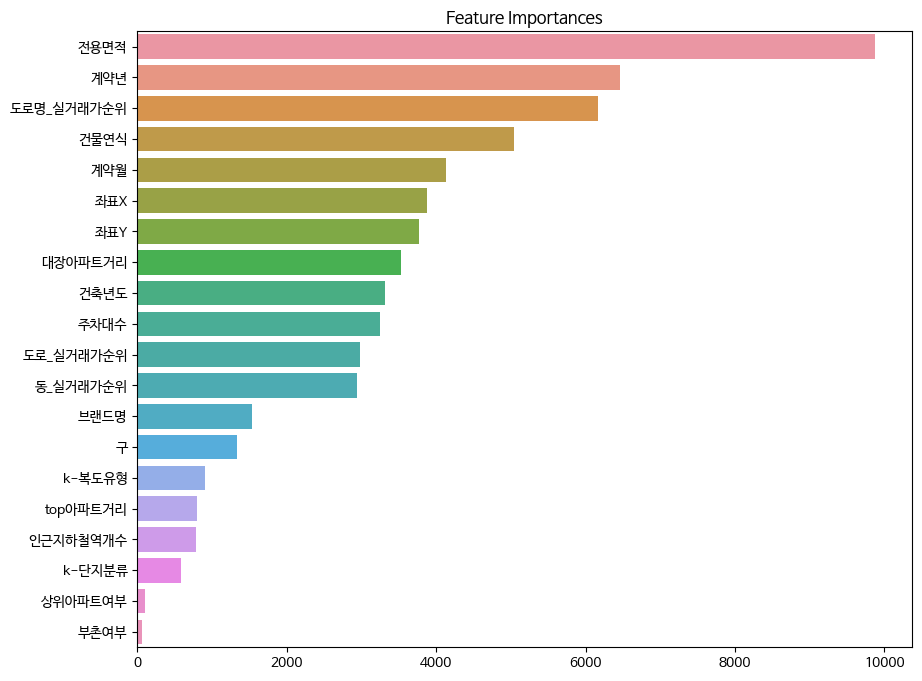

In [863]:
# ÏúÑ feature importanceÎ•º ÏãúÍ∞ÅÌôîÌï¥Î¥ÖÎãàÎã§.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [864]:
importances.tail(10)

ÎèÑÎ°ú_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ    2982
Îèô_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ     2944
Î∏åÎûúÎìúÎ™Ö         1534
Íµ¨            1336
k-Î≥µÎèÑÏú†Ìòï        905
topÏïÑÌååÌä∏Í±∞Î¶¨      800
Ïù∏Í∑ºÏßÄÌïòÏ≤†Ïó≠Í∞úÏàò      780
k-Îã®ÏßÄÎ∂ÑÎ•ò        580
ÏÉÅÏúÑÏïÑÌååÌä∏Ïó¨Î∂Ä       108
Î∂ÄÏ¥åÏó¨Î∂Ä           66
dtype: int32

In [865]:
# Ï†ÑÏ≤¥ train Îç∞Ïù¥ÌÑ∞Î°ú ÌïôÏäµÎêú Î™®Îç∏ÏùÑ Ï†ÄÏû•
model.fit(X_train_all, y_train_all)
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

[LightGBM] [Info] Total Bins 2431
[LightGBM] [Info] Number of data points in the train set: 3356484, number of used features: 20
[LightGBM] [Info] Start training from score 57998.550253


### 5.3. Feature selection

- Ïñ¥Îñ§ Î≥ÄÏàòÍ∞Ä Ïú†Ïö©Ìïú Î≥ÄÏàòÏù∏ÏßÄ ÌôïÏù∏Ìï¥Î≥¥Í∏∞ ÏúÑÌï¥ permutation selectionÏùÑ Ïù¥Ïö©Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.

In [866]:
# # Permutation importance Î∞©Î≤ïÏùÑ Î≥ÄÏàò ÏÑ†ÌÉùÏóê Ïù¥Ïö©Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.
# perm = PermutationImportance(model,        # ÏúÑÏóêÏÑú ÌïôÏäµÎêú Î™®Îç∏ÏùÑ Ïù¥Ïö©ÌïòÍ≤†ÏäµÎãàÎã§.
#                              scoring = 'neg_mean_squared_error',        # ÌèâÍ∞Ä ÏßÄÌëúÎ°úÎäî ÌöåÍ∑ÄÎ¨∏Ï†úÏù¥Í∏∞Ïóê negative rmseÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§. (neg_mean_squared_error : ÏùåÏùò ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞®)
#                              random_state = 42,
#                              n_iter=3).fit(X_val, y_val)
# eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid dataÏóê ÎåÄÌï¥ Ï†ÅÌï©ÏãúÌÇµÎãàÎã§.

### 5.4. Valid prediction Î∂ÑÏÑù

- ÏòàÏ∏°Í∞íÏùÑ Î∂ÑÏÑùÌï¥Î≥¥Í∏∞ ÏúÑÌï¥ valid predictionÏùÑ ÌôïÏù∏Ìï¥Î≥¥Í≤†ÏäµÎãàÎã§.

In [867]:
# Validation datasetÏóê targetÍ≥º pred Í∞íÏùÑ Ï±ÑÏõåÏ£ºÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.
X_val['target'] = y_val
X_val['pred'] = pred

# Squared_errorÎ•º Í≥ÑÏÇ∞ÌïòÎäî Ìï®ÏàòÎ•º Ï†ïÏùòÌïòÍ≤†ÏäµÎãàÎã§.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# SE Í≥ÑÏÇ∞
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

# ErrorÍ∞Ä ÌÅ∞ ÏàúÏÑúÎåÄÎ°ú sorting Ìï¥ Î≥¥Í≤†ÏäµÎãàÎã§.
X_val_sort = X_val.sort_values(by='error', ascending=False)    
X_val_sort.head(10)

ÎèÑÎ°úÎ™Ö_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ    Ï†ÑÏö©Î©¥Ï†Å  k-Î≥µÎèÑÏú†Ìòï  k-Îã®ÏßÄÎ∂ÑÎ•ò   Í≥ÑÏïΩÎÖÑ  Í≥ÑÏïΩÏõî  Îèô_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ         Ï¢åÌëúX  \
3356483           1  268.67       0       0  2022    4         9  127.010279   
1118827           1  268.67       0       0  2022    4         9  127.010279   
2237655           1  268.67       0       0  2022    4         9  127.010279   
1118824           1  268.67       0       0  2022    4         9  127.010279   
2237652           1  268.67       0       0  2022    4         9  127.010279   
2474319           1  268.67       0       0  2022    4         9  127.010279   
236663            1  268.67       0       0  2022    4         9  127.010279   
3356480           1  268.67       0       0  2022    4         9  127.010279   
1355491           1  268.67       0       0  2022    4         9  127.010279   
2462223           2  273.96       0       0  2022    4        15  127.052217   

               Ï¢åÌëúY  Í±¥Ï∂ïÎÖÑÎèÑ  ...  ÎèÑÎ°ú_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ   Íµ¨   Ï£ºÏ∞®ÎåÄÏàò  Ïù∏Í∑ºÏßÄÌïòÏ≤†Ïó≠Í∞úÏàò  Î∏åÎûúÎìúÎ™Ö  Í±¥Î¨ºÏó∞Ïãù  \
3356483  37.532642  2020  ...          4  20  476.0         1     1     2   
1118827  37.532642  2020  ...          4  20  476.0         1     1     2   
2237655  37.532642  2020  ...          4  20  476.0         1     1     2   
1118824  37.532642  2020  ...          4  20  476.0         1     1     2   
2237652  37.532642  2020  ...          4  20  476.0         1     1     2   
2474319  37.532642  2020  ...          4  20  476.0         1     1     2   
236663   37.532642  2020  ...          4  20  476.0         1     1     2   
3356480  37.532642  2020  ...          4  20  476.0         1     1     2   
1355491  37.532642  2020  ...          4  20  476.0         1     1     2   
2462223  37.526214  2020  ...          6   0  223.4         0     1     2   

         topÏïÑÌååÌä∏Í±∞Î¶¨     target           pred         error  
3356483  0.343202  1350000.0  490987.176405  7.379030e+11  
1118827  0.343202  1350000.0  490987.176405  7.379030e+11  
2237655  0.343202  1350000.0  490987.176405  7.379030e+11  
1118824  0.343202  1350000.0  490987.176405  7.379030e+11  
2237652  0.343202  1350000.0  490987.176405  7.379030e+11  
2474319  0.343202  1350000.0  490987.176405  7.379030e+11  
236663   0.343202  1350000.0  490987.176405  7.379030e+11  
3356480  0.343202  1350000.0  490987.176405  7.379030e+11  
1355491  0.343202  1350000.0  490987.176405  7.379030e+11  
2462223  0.152435  1450000.0  625192.433878  6.803075e+11  

[10 rows x 23 columns]

In [868]:
concat_select[concat_select['ÏïÑÌååÌä∏Î™Ö'] == 'PH129']

index   ÏïÑÌååÌä∏Î™Ö    Ï†ÑÏö©Î©¥Ï†Å    Í≥ÑÏïΩÎÖÑÏõî  Í≥ÑÏïΩÏùº   Ï∏µ  Í±¥Ï∂ïÎÖÑÎèÑ         ÎèÑÎ°úÎ™Ö     target  \
224566  224566  PH129  273.96  202111   25  10  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88   929070.0   
224567  224567  PH129  273.96  202204   28  16  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88  1450000.0   
241238  241238  PH129  273.96  202103    4  14  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88  1150000.0   
241239  241239  PH129  273.96  202107    7   6  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88  1000000.0   
224567  224567  PH129  273.96  202204   28  16  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88  1450000.0   
224567  224567  PH129  273.96  202204   28  16  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88  1450000.0   
224566  224566  PH129  273.96  202111   25  10  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88   929070.0   
224567  224567  PH129  273.96  202204   28  16  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88  1450000.0   
241238  241238  PH129  273.96  202103    4  14  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88  1150000.0   
241239  241239  PH129  273.96  202107    7   6  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88  1000000.0   
224567  224567  PH129  273.96  202204   28  16  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88  1450000.0   
224567  224567  PH129  273.96  202204   28  16  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88  1450000.0   
224566  224566  PH129  273.96  202111   25  10  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88   929070.0   
224567  224567  PH129  273.96  202204   28  16  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88  1450000.0   
241238  241238  PH129  273.96  202103    4  14  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88  1150000.0   
241239  241239  PH129  273.96  202107    7   6  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88  1000000.0   
224567  224567  PH129  273.96  202204   28  16  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88  1450000.0   
224567  224567  PH129  273.96  202204   28  16  2020  ÏïïÍµ¨Ï†ïÎ°ú79Í∏∏ 88  1450000.0   

        is_test  ... Î∂ÄÏ¥åÏó¨Î∂Ä  ÏÉÅÏúÑÏïÑÌååÌä∏Ïó¨Î∂Ä  topÏïÑÌååÌä∏Í±∞Î¶¨    Î∏åÎûúÎìúÎ™Ö Í±¥Î¨ºÏó∞Ïãù   ÎåÄÏû•ÏïÑÌååÌä∏Í±∞Î¶¨ Ïù∏Í∑ºÏßÄÌïòÏ≤†Ïó≠Í∞úÏàò  \
224566        0  ...    1        1  0.152435  others    1  2.339386        0   
224567        0  ...    1        1  0.152435  others    2  2.339386        0   
241238        0  ...    1        1  0.152435  others    1  2.339386        0   
241239        0  ...    1        1  0.152435  others    1  2.339386        0   
224567        0  ...    1        1  0.152435  others    2  2.339386        0   
224567        0  ...    1        1  0.152435  others    2  2.339386        0   
224566        0  ...    1        1  0.152435  others    1  2.339386        0   
224567        0  ...    1        1  0.152435  others    2  2.339386        0   
241238        0  ...    1        1  0.152435  others    1  2.339386        0   
241239        0  ...    1        1  0.152435  others    1  2.339386        0   
224567        0  ...    1        1  0.152435  others    2  2.339386        0   
224567        0  ...    1        1  0.152435  others    2  2.339386        0   
224566        0  ...    1        1  0.152435  others    1  2.339386        0   
224567        0  ...    1        1  0.152435  others    2  2.339386        0   
241238        0  ...    1        1  0.152435  others    1  2.339386        0   
241239        0  ...    1        1  0.152435  others    1  2.339386        0   
224567        0  ...    1        1  0.152435  others    2  2.339386        0   
224567        0  ...    1        1  0.152435  others    2  2.339386        0   

       ÎèÑÎ°úÎ™Ö_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ  ÎèÑÎ°ú_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ  Îèô_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ  
224566          2          6        15  
224567          2          6        15  
241238          2          6        15  
241239          2          6        15  
224567          2          6        15  
224567          2          6        15  
224566          2          6        15  
224567          2          6        15  
241238          2          6        15  
241239          2          6        15  
224567          2          6        15  
224567          2          6        15  
224566          2          6        15  
224567          2          6        15  
241238          2  

- ÏòàÏ∏°ÏùÑ Ïûò ÌïòÏßÄ Î™ªÌïú top 100Í∞úÏùò Îç∞Ïù¥ÌÑ∞ÏôÄ ÏòàÏ∏°ÏùÑ ÏûòÌïú top 100Í∞úÏùò Îç∞Ïù¥ÌÑ∞Î•º ÎπÑÍµêÌï¥Î≥¥Í≤†ÏäµÎãàÎã§.

In [869]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # ÏòàÏ∏°ÏùÑ Ïûò ÌïòÏßÄÎ™ªÌïú top 100Í∞úÏùò data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # ÏòàÏ∏°ÏùÑ ÏûòÌïú top 100Í∞úÏùò data

# Ìï¥ÏÑùÏùÑ ÏúÑÌï¥ Î†àÏù¥Î∏îÏù∏ÏΩîÎî© Îêú Î≥ÄÏàòÎ•º Î≥µÏõêÌï¥Ï§çÎãàÎã§.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # ÏïûÏÑú Î†àÏù¥Î∏î Ïù∏ÏΩîÎî©ÏóêÏÑú Ï†ïÏùòÌñàÎçò categorical_columns_v2 Î≤îÏ£ºÌòï Î≥ÄÏàò Î¶¨Ïä§Ìä∏Î•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # ÏïûÏÑú Î†àÏù¥Î∏î Ïù∏ÏΩîÎî©ÏóêÏÑú Ï†ïÏùòÌñàÎçò categorical_columns_v2 Î≤îÏ£ºÌòï Î≥ÄÏàò Î¶¨Ïä§Ìä∏Î•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

display(error_top100.head(1))
display(best_top100.head(1))

ÎèÑÎ°úÎ™Ö_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ    Ï†ÑÏö©Î©¥Ï†Å k-Î≥µÎèÑÏú†Ìòï k-Îã®ÏßÄÎ∂ÑÎ•ò   Í≥ÑÏïΩÎÖÑ  Í≥ÑÏïΩÏõî  Îèô_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ         Ï¢åÌëúX  \
3356483           1  268.67   NULL   NULL  2022    4         9  127.010279   

               Ï¢åÌëúY  Í±¥Ï∂ïÎÖÑÎèÑ  ...  ÎèÑÎ°ú_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ    Íµ¨   Ï£ºÏ∞®ÎåÄÏàò  Ïù∏Í∑ºÏßÄÌïòÏ≤†Ïó≠Í∞úÏàò    Î∏åÎûúÎìúÎ™Ö  Í±¥Î¨ºÏó∞Ïãù  \
3356483  37.532642  2020  ...          4  Ïö©ÏÇ∞Íµ¨  476.0         1  others     2   

         topÏïÑÌååÌä∏Í±∞Î¶¨     target           pred         error  
3356483  0.343202  1350000.0  490987.176405  7.379030e+11  

[1 rows x 23 columns]

ÎèÑÎ°úÎ™Ö_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ   Ï†ÑÏö©Î©¥Ï†Å k-Î≥µÎèÑÏú†Ìòï k-Îã®ÏßÄÎ∂ÑÎ•ò   Í≥ÑÏïΩÎÖÑ  Í≥ÑÏïΩÏõî  Îèô_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ         Ï¢åÌëúX  \
342715        4961  83.43   NULL   NULL  2020    6       220  127.066851   

              Ï¢åÌëúY  Í±¥Ï∂ïÎÖÑÎèÑ  ...  ÎèÑÎ°ú_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ     Íµ¨   Ï£ºÏ∞®ÎåÄÏàò  Ïù∏Í∑ºÏßÄÌïòÏ≤†Ïó≠Í∞úÏàò    Î∏åÎûúÎìúÎ™Ö  Í±¥Î¨ºÏó∞Ïãù  \
342715  37.570785  2009  ...        418  ÎèôÎåÄÎ¨∏Íµ¨  406.6         0  others    11   

        topÏïÑÌååÌä∏Í±∞Î¶¨   target          pred     error  
342715     500.0  42800.0  42797.601654  5.752061  

[1 rows x 23 columns]

- Ïù¥Ï†ú Î∂ÑÌè¨Î•º ÎπÑÍµêÌï¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

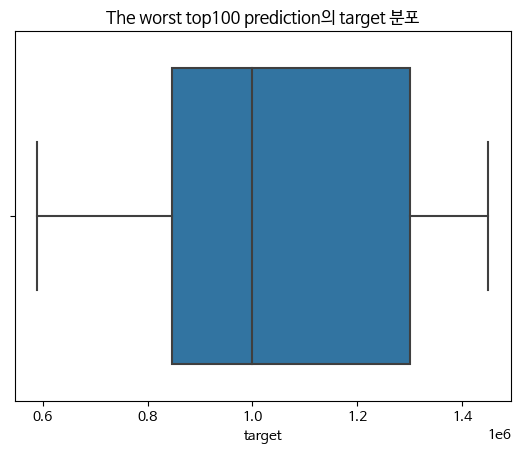

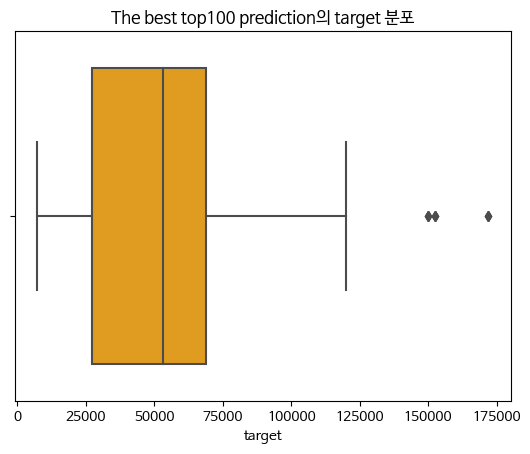

In [870]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 predictionÏùò target Î∂ÑÌè¨')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 predictionÏùò target Î∂ÑÌè¨')
plt.show()

- Taget Î∂ÑÌè¨Î•º Î≥¥Îãà Ï¢ãÏùÄ ÏòàÏ∏°ÏùÑ Î≥¥Ïù∏ top 100Í∞úÏùò dataÎ≥¥Îã§ ÏÉÅÎåÄÏ†ÅÏúºÎ°ú ÎÇòÏÅú ÏòàÏ∏°ÏùÑ Î≥¥Ïù∏ top 100 datasetÎì§Ïù¥ ÎÜíÏùÄ Í∞ÄÍ≤©ÏùÑ Î≥¥ÏòÄÏùåÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§. Ïù¥Ïóê ÎåÄÌïú Î™®Îç∏ÎßÅ Î∞è Ï≤òÎ¶¨Í∞Ä ÌïÑÏöîÌï¥Î≥¥ÏûÖÎãàÎã§.

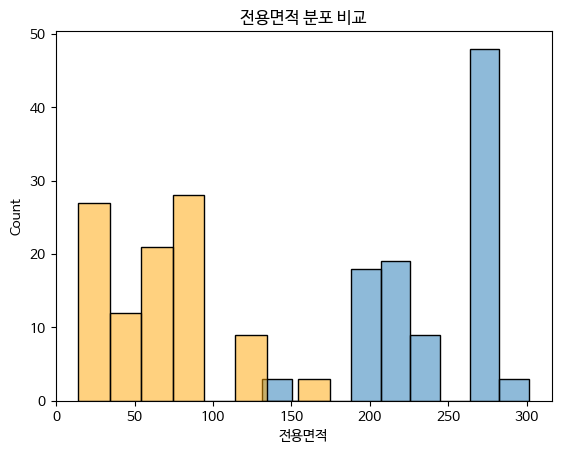

In [871]:
sns.histplot(data = error_top100, x='Ï†ÑÏö©Î©¥Ï†Å', alpha=0.5)
sns.histplot(data = best_top100, x='Ï†ÑÏö©Î©¥Ï†Å', color='orange', alpha=0.5)
plt.title('Ï†ÑÏö©Î©¥Ï†Å Î∂ÑÌè¨ ÎπÑÍµê')
plt.show()

- Ï†ÑÏö©Î©¥Ï†Å ÎòêÌïú ÎÇòÏÅú ÏòàÏ∏°ÏùÑ Î≥¥Ïù∏ ÏßëÎì§Ïù¥ Îçî ÎÑìÏùåÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

## 6. Inference

In [872]:
dt_test.head(2)      # test datasetÏóê ÎåÄÌïú inferenceÎ•º ÏßÑÌñâÌï¥Î≥¥Í≤†ÏäµÎãàÎã§.

ÎèÑÎ°úÎ™Ö_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ      Ï†ÑÏö©Î©¥Ï†Å  k-Î≥µÎèÑÏú†Ìòï  k-Îã®ÏßÄÎ∂ÑÎ•ò   Í≥ÑÏïΩÎÖÑ  Í≥ÑÏïΩÏõî  Îèô_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ         Ï¢åÌëúX  \
0         927   79.9700       1       3  2023    7        48  127.057210   
1        1127  108.2017       1       3  2023    8        48  127.056394   

         Ï¢åÌëúY  Í±¥Ï∂ïÎÖÑÎèÑ  ...   ÎåÄÏû•ÏïÑÌååÌä∏Í±∞Î¶¨  ÎèÑÎ°ú_Ïã§Í±∞ÎûòÍ∞ÄÏàúÏúÑ  Íµ¨   Ï£ºÏ∞®ÎåÄÏàò  Ïù∏Í∑ºÏßÄÌïòÏ≤†Ïó≠Í∞úÏàò  Î∏åÎûúÎìúÎ™Ö  Í±¥Î¨ºÏó∞Ïãù  \
0  37.476763  1987  ...  6.578607         35  0  262.0         0    23    36   
1  37.484892  2021  ...  5.734605         77  0  305.0         1     6     2   

      Í≥ÑÏïΩÎÖÑÏõîÏùº  topÏïÑÌååÌä∏Í±∞Î¶¨  target  
0  20230726     500.0     NaN  
1  20230815     500.0     NaN  

[2 rows x 22 columns]

In [873]:
# Ï†ÄÏû•Îêú Î™®Îç∏ÏùÑ Î∂àÎü¨ÏòµÎãàÎã§.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [874]:
%%time
X_test = dt_test.drop(['target', 'Í≥ÑÏïΩÎÖÑÏõîÏùº'], axis=1)

# Test datasetÏóê ÎåÄÌïú inferenceÎ•º ÏßÑÌñâÌï©ÎãàÎã§.
real_test_pred = model.predict(X_test)

CPU times: user 703 ms, sys: 0 ns, total: 703 ms
Wall time: 83.5 ms


In [875]:
real_test_pred          # ÏòàÏ∏°Í∞íÎì§Ïù¥ Ï∂úÎ†•Îê®ÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

array([191919.72288302, 278490.98872323, 330501.55231577, ...,
        83022.76029312,  73590.98140258,  73674.76049305])

## 7. Output File Save

In [876]:
# ÏïûÏÑú ÏòàÏ∏°Ìïú ÏòàÏ∏°Í∞íÎì§ÏùÑ Ï†ÄÏû•Ìï©ÎãàÎã§.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

In [877]:
y_test = pd.read_csv('../y_test.csv')
print(f"RMSE test: {mean_squared_error(y_test, preds_df, squared=False)}")

RMSE test: 12710.405579350629
